# Оптимизация системы управления персоналом

**Краткая информация о проекте:**
В проекте проводится прогнозирование уровня удовлетворённости сотрудников и увольнения сотрудника из компании с помощью моделей машинного обучения.В процессе выполения проекта проводится:

- Знакомство и предобработка данных;
- Исследовательский анализ данных (описание и визуализация);
- Корреляционный анализ (количественных и качественных признаков);
- Обучение и выбор лучшей модели машинного обучения для прогнозирования уровня удовлетворённости сотрудников;
- Обучение и выбор лучшей модели машинного обучения для прогнозирования увольнения сотрудника из компании.

**План работы:**
1. Провести загрузку данных и знакомство с ними;
2. Провести предобработку данных;
3. Провести исследовательских анализ данных (описание и визуализацию);
4. Провести корреляционный анализ (количественных и качественных признаков);
5. Провести выбор и обучение модели с дальнейшим прогнозированием уровня удовлетворённости сотрудников (задача регрессии);
6. Провести выбор и обучение модели с дальнейшим прогнозированием увольнения сотрудника из компании (задача классификации).

**Цель и задачи проекта:**
- **Цель** - оптимизировать систему управления персоналом с помощью разработки моделей МО.
- **Задачи:**
1. Провести загрузку данных и знакомство с ними;
2. Провести предобработку данных;
- Обработать дубликаты и пропуски
3. Провести исследовательских анализ данных (описание и визуализацию);
- Рассмотреть распределение количественных и качественных признаков полученных датафреймов.
4. Провести корреляционный анализ (количественных и качественных признаков);
- Определить корреляцию между количественными и качественными признаками;
- Построить графики рассеивания по различным признакам;
- Построить графики "ящик с усами" по различным признакам.
5. Провести выбор и обучение модели с дальнейшим прогнозированием уровня удовлетворённости сотрудников;
- Подготовить пайплайн для обучения модели;
- Провести подбор гиперпараметров c помощью специальных функций;
- Определить лучшую модель по выбранной метрики качества.
6. Провести выбор и обучение модели с дальнейшим прогнозированием увольнения сотрудника из компании;
- Подготовить пайплайн для обучения модели;
- Провести подбор гиперпараметров c помощью специальных функций;
- Определить лучшую модель по выбранной метрики качества.

In [7]:
!pip install phik -q
!pip install shap -q
!pip install -q -U scikit-learn

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os

from scipy import stats as st
from phik.report import correlation_report, plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, LabelEncoder,
                                   StandardScaler, RobustScaler)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, make_scorer

## Загрузка данных

In [9]:
for i, path in enumerate (['train_job_satisfaction_rate.csv', 'train_quit.csv', 'test_features.csv', 
                           'test_target_job_satisfaction_rate.csv', 'test_target_quit.csv']):
    data_path = os.path.join(os.getcwd(), path)
    if i == 0:
        train_job_satisfaction_rate = pd.read_csv(data_path)
    elif i == 1:
        train_quit = pd.read_csv(data_path)
    elif i == 2:
        test_features = pd.read_csv(data_path)
    elif i == 3:
        test_target_job_satisfaction_rate = pd.read_csv(data_path)
    else:
        test_target_quit = pd.read_csv(data_path)

### Предварительное ознакомление с датафреймом `train_job_satisfaction_rate`

In [10]:
display([x for x in train_job_satisfaction_rate['id'] if x in train_quit['id']])

[]

In [5]:
display(test_target_quit.head())
test_target_quit.info()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [6]:
display(train_job_satisfaction_rate.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
train_job_satisfaction_rate.info()
display(train_job_satisfaction_rate.sort_values('id').head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
560,100954,purchasing,junior,low,1,no,no,4,15600,0.60
1124,101057,sales,junior,low,1,no,yes,4,19200,0.45
1509,101074,sales,junior,medium,2,no,no,2,20400,0.36
2106,101081,sales,middle,low,2,no,no,4,28800,0.66
405,101129,technology,junior,medium,1,no,no,4,34800,0.71


Судя по полученной информации, в датафрейме есть пропуски в двух столбцах: `dept`, `level`.

### Предварительное ознакомление с датафреймом `train_quit`

In [7]:
train_quit.info()
display(train_quit.sort_values('id').head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2600,100222,sales,junior,medium,3,no,no,2,20400,yes
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes
2455,100469,marketing,junior,medium,1,no,no,4,28800,no
1592,100601,technology,middle,high,4,no,no,4,68400,no
2657,100858,sales,junior,medium,2,no,no,4,25200,yes


In [8]:
display(len([x for x in train_quit['id'].unique() if x not in train_job_satisfaction_rate['id'].unique()]))

4000

В данных отсутствуют пропуски. Выборки `train_job_satisfaction_rate` и `train_quit`, исходя из значений `id` полностью отличаются. Следовательно анализировать данные и тренировать модели МО потребуется отдельно друг от друга.

### Предварительное ознакомление с датафреймом `test_features`

In [9]:
test_features.info()
display(test_features.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Судя по полученной информации, в датафрейме есть пропуски в двух столбцах: `dept`, `level`.

### Предварительное ознакомление с датафреймом `test_target_job_satisfaction_rate`

In [10]:
test_target_job_satisfaction_rate.info()
display(test_target_job_satisfaction_rate.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


### Предварительное ознакомление с датафреймом `test_target_quit`

In [11]:
test_target_quit.info()
display(test_target_quit.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


### Подготовка датафреймов к работе - перенос 'id' в индексы

Установим `id` в индекс у датафрейма `train_job_satisfaction_rate`

In [12]:
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')

Установим `id` в индекс у датафрейма `train_quit`

In [13]:
train_quit = train_quit.set_index('id')

Установим `id` в индекс у датафрейма `test_features`

In [14]:
test_features = test_features.set_index('id')
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.set_index('id')
test_target_quit = test_target_quit.set_index('id')

### Выводы по разделу

- Для каждого целевого таргета получены тренировочные данные в количестве **4 000** наблюдений и тестовые данные в количестве **2 000** наблюдений;
- В датафреймах для прогнозирования уровня удовлетворенности сотрудников есть пропуски в столбцах `dept` и `level`;
- При работе с тестовыми данными необходимо сопоставить датафрейму по столбцу `id`, так как индексы не соответствуют.

##  Предобработка данных

### Обработка датафрейма `train_job_satisfaction_rate`

#### Обработка пропусков

In [15]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


В датафрейме присутствуют пропуски в двух столбцах

In [16]:
display(train_job_satisfaction_rate[train_job_satisfaction_rate['dept'].isna()])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
694746,NaN,junior,medium,5,no,no,4,21600,0.62
814624,NaN,junior,medium,3,no,no,4,24000,0.88
475114,NaN,junior,high,4,no,no,4,31200,0.63
497243,NaN,junior,medium,1,no,no,3,26400,0.28
168668,NaN,junior,low,3,no,no,4,18000,0.88
641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [17]:
display(train_job_satisfaction_rate[train_job_satisfaction_rate['level'].isna()])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
631073,sales,NaN,medium,1,no,no,4,27600,0.66
416327,sales,NaN,low,1,no,no,5,18000,0.73
135043,sales,NaN,medium,1,no,no,3,26400,0.30
998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [18]:
imput_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

imput_pipe_data = train_job_satisfaction_rate.drop(columns=['job_satisfaction_rate'])
job = pd.DataFrame(train_job_satisfaction_rate['job_satisfaction_rate'], columns=['job_satisfaction_rate'])

In [19]:
imput_pipe_data = pd.DataFrame(imput_pipe.fit_transform(imput_pipe_data), 
                               columns=imput_pipe_data.columns, index=imput_pipe_data.index)

In [20]:
train_job_satisfaction_rate = imput_pipe_data.join(job)

In [21]:
train_job_satisfaction_rate['employment_years'] = train_job_satisfaction_rate['employment_years'].astype('int64')
train_job_satisfaction_rate['supervisor_evaluation'] = train_job_satisfaction_rate['supervisor_evaluation'].astype('int64')
train_job_satisfaction_rate['salary'] = train_job_satisfaction_rate['salary'].astype('int64')

In [22]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 441.5+ KB


#### Обработка дубликатов

In [23]:
display(train_job_satisfaction_rate.duplicated().sum())

248

В датафрейме присутствуют **248** явных дубликатов. Для дальнейшей работы удалим их.

In [24]:
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()
display(train_job_satisfaction_rate.duplicated().sum())

0

In [25]:
cat_features = train_job_satisfaction_rate.select_dtypes(include=['object']).columns

for col in cat_features:
    display(col, train_job_satisfaction_rate[col].unique())

'dept'

array(['sales', 'hr', 'technology', 'purchasing', 'marketing'],
      dtype=object)

'level'

array(['junior', 'middle', 'sinior'], dtype=object)

'workload'

array(['medium', 'high', 'low'], dtype=object)

'last_year_promo'

array(['no', 'yes'], dtype=object)

'last_year_violations'

array(['no', 'yes'], dtype=object)

Обработаем ошибку в написании в столбце `level`

In [26]:
train_job_satisfaction_rate = train_job_satisfaction_rate.replace({'sinior': 'senior'})

### Обработка датафрейма `train_quit`

#### Обработка пропусков

In [27]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


В датафрейме отсутствуют пропуски

#### Обработка дубликатов

In [28]:
display(train_quit.duplicated().sum())

1413

In [29]:
display(train_quit[train_quit.duplicated()]['quit'].value_counts())
display(train_quit['quit'].value_counts())

no     940
yes    473
Name: quit, dtype: int64

no     2872
yes    1128
Name: quit, dtype: int64

В датафрейме присутствует **1413** явных дубликатов. В связи с тем, что дубликаты распределены, примерно, соразмерно двум классам, удалим их для точности дальнейшей работы.

In [30]:
train_quit = train_quit.drop_duplicates()
display(train_quit.duplicated().sum())

0

In [31]:
cat_features_1 = train_quit.select_dtypes(include=['object']).columns

for col in cat_features_1:
    display(col, train_quit[col].unique())

'dept'

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

'level'

array(['middle', 'junior', 'sinior'], dtype=object)

'workload'

array(['high', 'medium', 'low'], dtype=object)

'last_year_promo'

array(['no', 'yes'], dtype=object)

'last_year_violations'

array(['no', 'yes'], dtype=object)

'quit'

array(['no', 'yes'], dtype=object)

Обработаем ошибку в написании в столбце `level`

In [32]:
train_quit = train_quit.replace({'sinior': 'senior'})

### Обработка датафрейма `test_features`

#### Обработка пропусков

In [33]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


В датафрейме присутствуют пропуски в двух столбцах

In [34]:
test_features = pd.DataFrame(imput_pipe.transform(test_features), columns=test_features.columns, index=test_features.index)

In [35]:
test_features['employment_years'] = test_features['employment_years'].astype('int64')
test_features['supervisor_evaluation'] = test_features['supervisor_evaluation'].astype('int64')
test_features['salary'] = test_features['salary'].astype('int64')

In [36]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   2000 non-null   object
 1   level                  2000 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


#### Обработка дубликатов

In [37]:
display(test_features.duplicated().sum())

560

В датафрейме присутствуют явные дубликаты, но так как это тестовая выборка, оставим ее без изменений.

In [38]:
cat_features = test_features.select_dtypes(include=['object']).columns

for col in cat_features:
    display(col, test_features[col].unique())

'dept'

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', ' '],
      dtype=object)

'level'

array(['junior', 'middle', 'sinior'], dtype=object)

'workload'

array(['medium', 'low', 'high', ' '], dtype=object)

'last_year_promo'

array(['no', 'yes'], dtype=object)

'last_year_violations'

array(['no', 'yes'], dtype=object)

In [39]:
test_features = test_features.replace({'sinior': 'senior'})

В датафрейме есть неявные пропуски в столбцах `dept` и `workload`

In [40]:
display(test_features[test_features['dept'] == ' '])
display(test_features[test_features['workload'] == ' '])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
822186,,middle,medium,3,no,no,4,38400


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
590867,marketing,junior,,4,no,no,4,28800


Обработаем неявные пропуски, задав самое частое значение в столбце

In [41]:
test_features = test_features.replace({' ': np.nan})

Подготовим тестовые данные для дальнейшего анализа

In [42]:
data_test = test_features.join(test_target_job_satisfaction_rate)
data_test = data_test.join(test_target_quit)
data_test = data_test.reset_index(drop=True)

### Выводы по разделу

- В процессе предобработки данных был проведен первичный анализ данных, по результатом которых были выявлены и заполнены пропуски;
- Столбец `id` установлен в индекс.

## Исследовательский анализ данных

### Статистический анализ данных

#### Статистический анализ признаков датафрейма `train_job_satisfaction_rate`

In [43]:
display(train_job_satisfaction_rate.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


Посмотрим статистические данные по количественным столбцам и построим графики boxplot

,salary,job_satisfaction_rate
count,3752.000000,3752.000000
mean,34463.219616,0.532535
std,15055.252759,0.226424
min,12000.000000,0.030000
25%,22800.000000,0.350000
50%,31200.000000,0.550000
75%,44400.000000,0.710000
max,98400.000000,1.000000


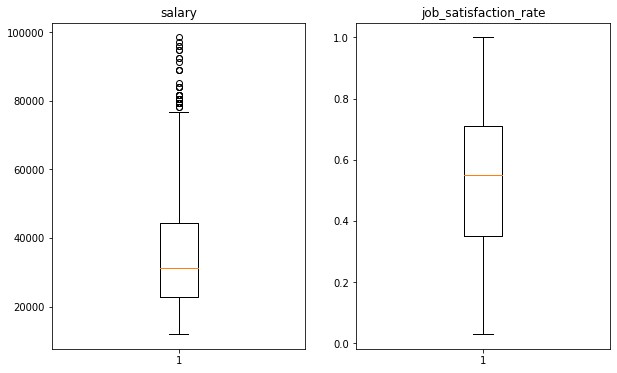

In [44]:
num_cont_features = ['salary', 'job_satisfaction_rate']

fig, ax = plt.subplots(1, len(num_cont_features), figsize=(10, 6))

display(train_job_satisfaction_rate[num_cont_features].describe())
for i, col in enumerate(num_cont_features):
    ax[i].boxplot(train_job_satisfaction_rate[col])
    ax[i].set_title(col)
    

plt.show()

- Присутствуют выбросы в `salary`. Данные выбросы обрабатываться не будут по причине естественности положения вещей.

#### Статистический анализ признаков датафрейма `train_quit`

In [45]:
display(train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


Посмотрим статистические данные по количественным столбцам и построим графики boxplot

count     2587.000000
mean     37107.692308
std      16267.354906
min      12000.000000
25%      24000.000000
50%      33600.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

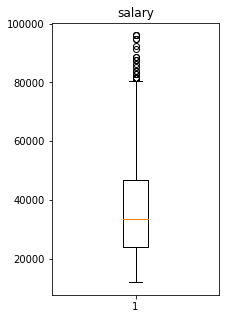

In [46]:
display(train_quit['salary'].describe())

plt.figure(figsize=(3,5))
plt.boxplot(train_quit['salary'])
plt.title('salary')
    
plt.show()

- Присутствуют выбросы в `salary`. Данные выбросы обрабатываться не будут по причине естественности положения вещей.

#### Статистический анализ признаков датафрейма `test_features`

In [47]:
display(data_test.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,hr,junior,medium,1,no,no,4,30000,0.72,no
2,sales,middle,low,5,no,no,4,19200,0.64,no
3,sales,middle,low,6,no,no,4,19200,0.60,no
4,hr,middle,medium,5,no,no,5,40800,0.75,no


Посмотрим статистические данные по количественным столбцам и построим графики boxplot

,salary,job_satisfaction_rate
count,2000.000000,2000.00000
mean,34066.800000,0.54878
std,15398.436729,0.22011
min,12000.000000,0.03000
25%,22800.000000,0.38000
50%,30000.000000,0.58000
75%,43200.000000,0.72000
max,96000.000000,1.00000


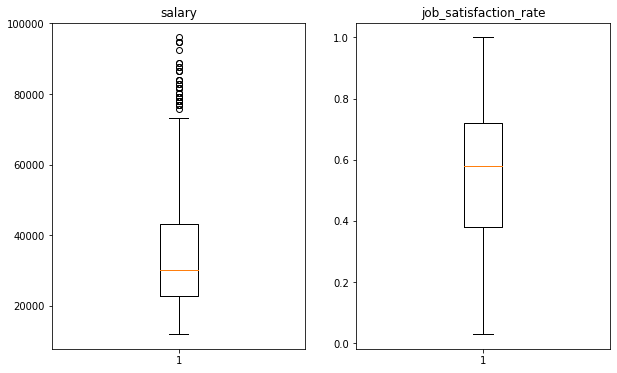

In [48]:
num_cont_features = ['salary', 'job_satisfaction_rate']

fig, ax = plt.subplots(1, len(num_cont_features), figsize=(10, 6))

display(data_test[num_cont_features].describe())
for i, col in enumerate(num_cont_features):
    ax[i].boxplot(data_test[col])
    ax[i].set_title(col)
    

plt.show()

- Присутствуют выбросы в `salary`. Данные выбросы обрабатываться не будут по причине естественности положения вещей.

#### Проверка соответствия уровня зарплат из двух датафреймов `train_job_satisfaction_rate` и `train_quit`

Н0: Среднее значение уровня зарплат в датафреймах `train_job_satisfaction_rate` и `train_quit` равны.

Н1: Среднее значение уровня зарплат в датафреймах `train_job_satisfaction_rate` и `train_quit` не равны.

In [49]:
salary_job = train_job_satisfaction_rate['salary']
salary_quit = train_quit['salary']
display('Среднее значение уровня зарплат в датафрейме train_job_satisfaction_rate: {:.3f}'.format(salary_job.mean()))
display('Среднее значение уровня зарплат в датафрейме train_quit: {:.3f}'.format(salary_quit.mean()))

alpha = 0.01
result = st.ttest_ind(salary_job, salary_quit)
display('pvalue равен: {:.3f}'.format(result.pvalue))
if result.pvalue < alpha:
    display('Уровень зарплат из train_job_satisfaction_rate отличается от уровеня зарплат из train_quit')
else:
    display('Уровень зарплат из train_job_satisfaction_rate не отличается от уровеня зарплат из train_quit')

'Среднее значение уровня зарплат в датафрейме train_job_satisfaction_rate: 34463.220'

'Среднее значение уровня зарплат в датафрейме train_quit: 37107.692'

'pvalue равен: 0.000'

'Уровень зарплат из train_job_satisfaction_rate отличается от уровеня зарплат из train_quit'

#### Проверка соответствия уровня зарплат из двух датафреймов `train_job_satisfaction_rate` и `data_test`

Н0: Среднее значение уровня зарплат в датафреймах `train_job_satisfaction_rate` и `data_test` равны.

Н1: Среднее значение уровня зарплат в датафреймах `train_job_satisfaction_rate` и `data_test` не равны.

In [50]:
salary_job = train_job_satisfaction_rate['salary']
salary_test = data_test['salary']
display('Среднее значение уровня зарплат в датафрейме train_job_satisfaction_rate: {:.3f}'.format(salary_job.mean()))
display('Среднее значение уровня зарплат в датафрейме data_test: {:.3f}'.format(salary_test.mean()))

alpha = 0.01
result = st.ttest_ind(salary_job, salary_test)
display('pvalue равен: {:.3f}'.format(result.pvalue))
if result.pvalue < alpha:
    display('Уровень зарплат из train_job_satisfaction_rate отличается от уровеня зарплат из data_test')
else:
    display('Уровень зарплат из train_job_satisfaction_rate не отличается от уровеня зарплат из data_test')

'Среднее значение уровня зарплат в датафрейме train_job_satisfaction_rate: 34463.220'

'Среднее значение уровня зарплат в датафрейме data_test: 34066.800'

'pvalue равен: 0.345'

'Уровень зарплат из train_job_satisfaction_rate не отличается от уровеня зарплат из data_test'

### Визуализация данных

#### Визуализация количественных значений датафрейма `train_job_satisfaction_rate`

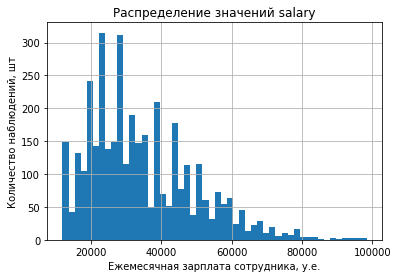

'Распределение salary не относится к нормальному'

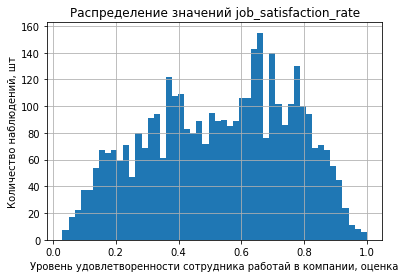

'Распределение job_satisfaction_rate не относится к нормальному'

In [51]:
axes_name = {'salary': ['Ежемесячная зарплата сотрудника', ', у.е.'],
            'job_satisfaction_rate': ['Уровень удовлетворенности сотрудника работай в компании',
                                      ', оценка'],}

for i in range(len(num_cont_features)):
    plt.hist(train_job_satisfaction_rate[num_cont_features[i]], bins=50)
    plt.title(f'Распределение значений {num_cont_features[i]}')
    plt.xlabel(axes_name[num_cont_features[i]][0] + axes_name[num_cont_features[i]][1])
    plt.ylabel('Количество наблюдений, шт')
    plt.grid()
    plt.show()
    val = st.shapiro(train_job_satisfaction_rate[num_cont_features[i]]).pvalue
    if val < 0.05:
        display(f'Распределение {num_cont_features[i]} не относится к нормальному')
    else:
        display(f'Распределение {num_cont_features[i]} относится к нормальному')

Выводы по графикам **непрерывных количественных признаков**:
- Значения в столбце `job_satisfaction_rate` имеют вид, приближенный к нормальному распределению;
- Значения в столбце `salary` имеют вид, приближенный к гамма распределению.

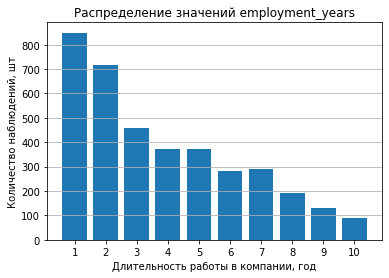

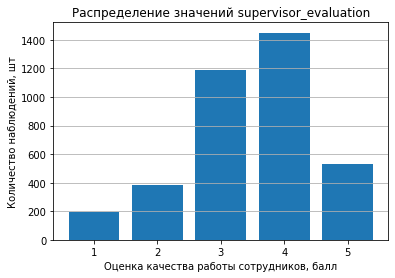

In [52]:
num_dis_features = ['employment_years', 'supervisor_evaluation']

for col in num_dis_features:
    table = train_job_satisfaction_rate[col].value_counts()
    plt.bar(table.index, table.values)
    plt.title(f'Распределение значений {col}')
    plt.ylabel('Количество наблюдений, шт')
    if col == 'employment_years':
        plt.xlabel('Длительность работы в компании, год')
        plt.xticks(range(1, 11))
    else:
        plt.xlabel('Оценка качества работы сотрудников, балл')
    plt.grid(axis='y')
    plt.show()

Выводы по графикам **дискретных количественных признаков**:
- Значения в столбце `employment_years` имеют вид, приближенный к гамма распределению;
- Значения в столбце `supervisor_evaluation` имеют вид, приближенный к бета распределению.

#### Визуализация количественных значений датафрейма `train_quit`

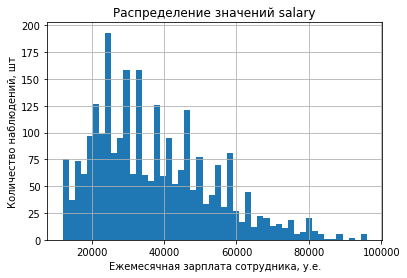

'Распределение salary не относится к нормальному'

In [53]:
axes_name = {'salary': ['Ежемесячная зарплата сотрудника', ', у.е.']}

plt.hist(train_quit['salary'], bins=50)
plt.title('Распределение значений salary')
plt.xlabel('Ежемесячная зарплата сотрудника, у.е.')
plt.ylabel('Количество наблюдений, шт')
plt.grid()
plt.show()
val = st.shapiro(train_quit['salary']).pvalue
if val < 0.05:
    display('Распределение salary не относится к нормальному')
else:
    display('Распределение salary относится к нормальному')

Выводы по графикам **непрерывных количественных признаков**:
- Значения в столбце `salary` имеют вид, приближенный к гамма распределению.

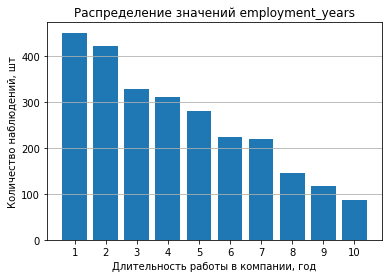

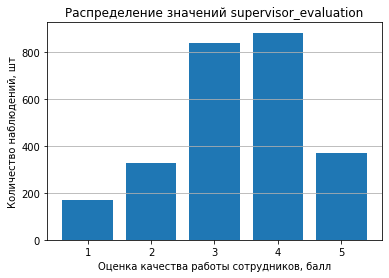

In [54]:
num_dis_features = ['employment_years', 'supervisor_evaluation']

for col in num_dis_features:
    table = train_quit[col].value_counts()
    plt.bar(table.index, table.values)
    plt.title(f'Распределение значений {col}')
    plt.ylabel('Количество наблюдений, шт')
    if col == 'employment_years':
        plt.xlabel('Длительность работы в компании, год')
        plt.xticks(range(1, 11))
    else:
        plt.xlabel('Оценка качества работы сотрудников, балл')
    plt.grid(axis='y')
    plt.show()

Выводы по графикам **дискретных количественных признаков**:
- Значения в столбце `employment_years` имеют вид, приближенный к гамма распределению;
- Значения в столбце `supervisor_evaluation` имеют вид, приближенный к бета распределению.

#### Визуализация количественных значений датафрейма `data_test`

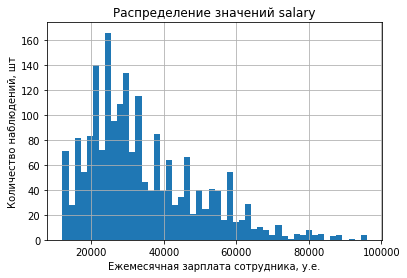

'Распределение salary не относится к нормальному'

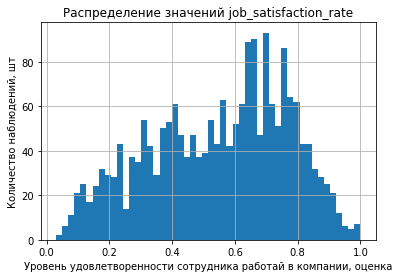

'Распределение job_satisfaction_rate не относится к нормальному'

In [55]:
axes_name = {'salary': ['Ежемесячная зарплата сотрудника', ', у.е.'],
            'job_satisfaction_rate': ['Уровень удовлетворенности сотрудника работай в компании',
                                      ', оценка'],}

for i in range(len(num_cont_features)):
    plt.hist(data_test[num_cont_features[i]], bins=50)
    plt.title(f'Распределение значений {num_cont_features[i]}')
    plt.xlabel(axes_name[num_cont_features[i]][0] + axes_name[num_cont_features[i]][1])
    plt.ylabel('Количество наблюдений, шт')
    plt.grid()
    plt.show()
    val = st.shapiro(data_test[num_cont_features[i]]).pvalue
    if val < 0.05:
        display(f'Распределение {num_cont_features[i]} не относится к нормальному')
    else:
        display(f'Распределение {num_cont_features[i]} относится к нормальному')

Выводы по графикам **непрерывных количественных признаков**:
- Значения в столбце `job_satisfaction_rate` имеют вид, приближенный к бета распределению;
- Значения в столбце `salary` имеют вид, приближенный к гамма распределению.

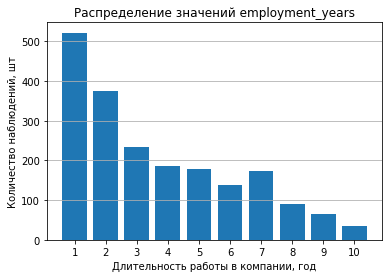

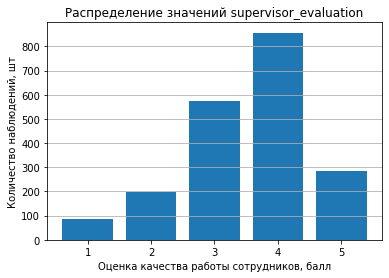

In [56]:
num_dis_features = ['employment_years', 'supervisor_evaluation']

for col in num_dis_features:
    table = data_test[col].value_counts()
    plt.bar(table.index, table.values)
    plt.title(f'Распределение значений {col}')
    plt.ylabel('Количество наблюдений, шт')
    if col == 'employment_years':
        plt.xlabel('Длительность работы в компании, год')
        plt.xticks(range(1, 11))
    else:
        plt.xlabel('Оценка качества работы сотрудников, балл')
    plt.grid(axis='y')
    plt.show()

Выводы по графикам **дискретных количественных признаков**:
- Значения в столбце `employment_years` имеют вид, приближенный к гамма распределению;
- Значения в столбце `supervisor_evaluation` имеют вид, приближенный к бета распределению.

#### Визуализация качественных значений датафрейма `train_job_satisfaction_rate`

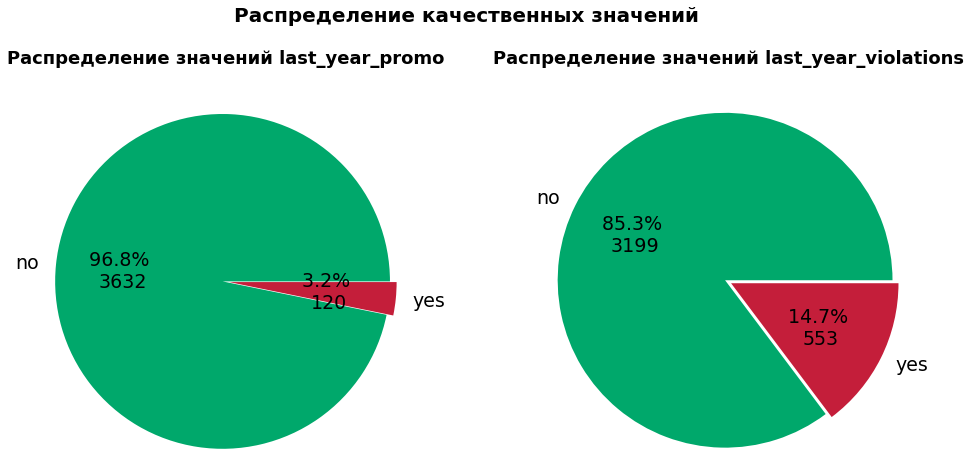

In [57]:
def percent(pct, table):
    absolute = int(round(pct/100 * table.sum()))
    return f"{pct:.1f}% \n{absolute}"

fig, ax = plt.subplots(1, len(cat_features[3:]), figsize=(12, 8))
fig.suptitle('Распределение качественных значений', size=20, weight='bold')
plt.subplots_adjust(wspace=2)
colors = ['#00A86B', '#C41E3A']

for ind, column in enumerate(cat_features[3:]):
    table = train_job_satisfaction_rate[column].value_counts()
    wedges, texts, autotexts = ax[ind].pie(table, autopct=lambda pct: percent(pct, table), colors=colors,
                                           radius=2.5, labels=table.index, explode=[0.05 for i in range(len(table.index))])
    plt.setp(autotexts, size=19)
    plt.setp(texts, size=19)
    ax[ind].set_title(f'Распределение значений {column}', y=1.8, pad=1, fontsize=18, weight='bold')

plt.show()

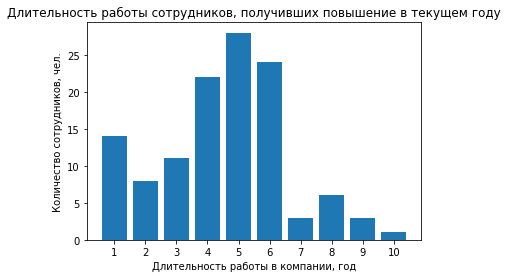

In [58]:
promo = train_job_satisfaction_rate[train_job_satisfaction_rate['last_year_promo'] == 'yes']

table = promo['employment_years'].value_counts()
plt.bar(table.index, table.values)
plt.title(f'Длительность работы сотрудников, получивших повышение в текущем году')
plt.ylabel('Количество сотрудников, чел.')
plt.xlabel('Длительность работы в компании, год')
plt.xticks(range(1, 11))

plt.show()

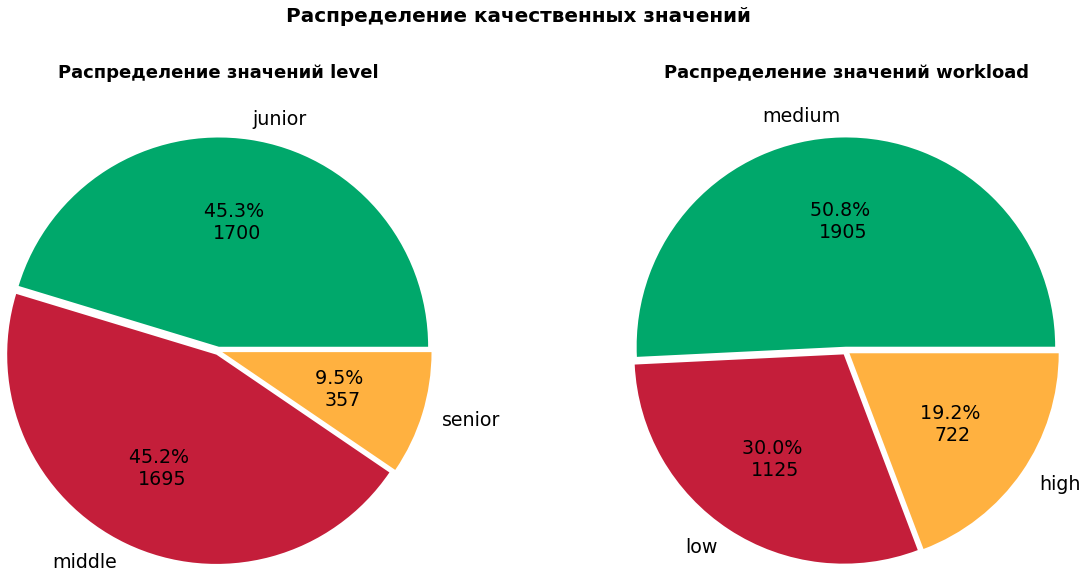

In [59]:
fig, ax = plt.subplots(1, len(cat_features[1:3]), figsize=(15, 10))
fig.suptitle('Распределение качественных значений', size=20, weight='bold')
plt.subplots_adjust(wspace=2)
colors = ['#00A86B', '#C41E3A', '#FFB140']

for ind, column in enumerate(cat_features[1:3]):
    table = train_job_satisfaction_rate[column].value_counts()
    wedges, texts, autotexts = ax[ind].pie(table, autopct=lambda pct: percent(pct, table), colors=colors,
                                           radius=2.5, labels=table.index, explode=[0.05 for i in range(len(table.index))])
    plt.setp(autotexts, size=19)
    plt.setp(texts, size=19)
    ax[ind].set_title(f'Распределение значений {column}', y=1.8, pad=1, fontsize=18, weight='bold')

plt.show()

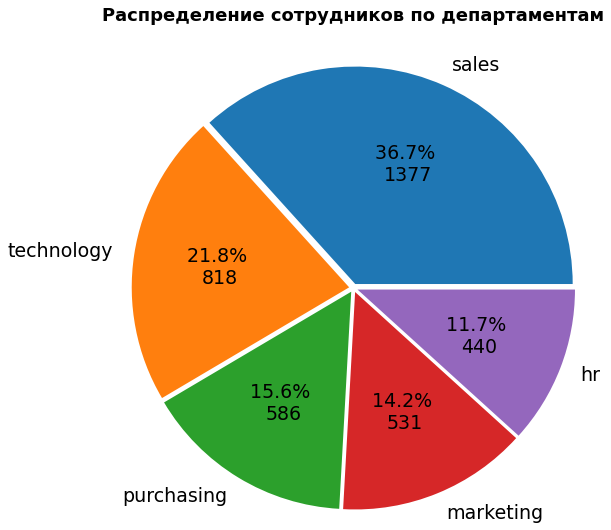

In [60]:
table = train_job_satisfaction_rate[cat_features[0]].value_counts()
wedges, texts, autotexts = plt.pie(table, autopct=lambda pct: percent(pct, table), 
                                   radius=2.5, labels=table.index, explode=[0.05 for i in range(len(table.index))])
plt.setp(autotexts, size=19)
plt.setp(texts, size=19)
plt.title('Распределение сотрудников по департаментам', y=1.7, fontsize=18, weight='bold')
    

plt.show()

Выводы по графикам **качественных признаков**:
- Во входном признаке `last_year_promo` наблюдается значительный дисбаланс меток. Только 3% сотрудников получали повышение за последний год;
- Во входном признаке `last_year_violations` наблюдается значительный дисбаланс меток. 14% сотрудников нарушали трудовой договор за последний год;
- Во входном признаке `level` всего лишь 10% senior, midle и junior - 45% и 45% соответственно;
- Во входном признаке `workload` загруженность распределена следующим образом: low - 30%, medium - 51%, high - 19%;
- Во входном признаке `dept` большая часть сотрудников работает в отделе продаж (37%), и технологии (22%), в остальных отделах 11-15 % в каждом.

#### Визуализация качественных значений датафрейма `train_quit`

In [61]:
display(cat_features)

Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object')

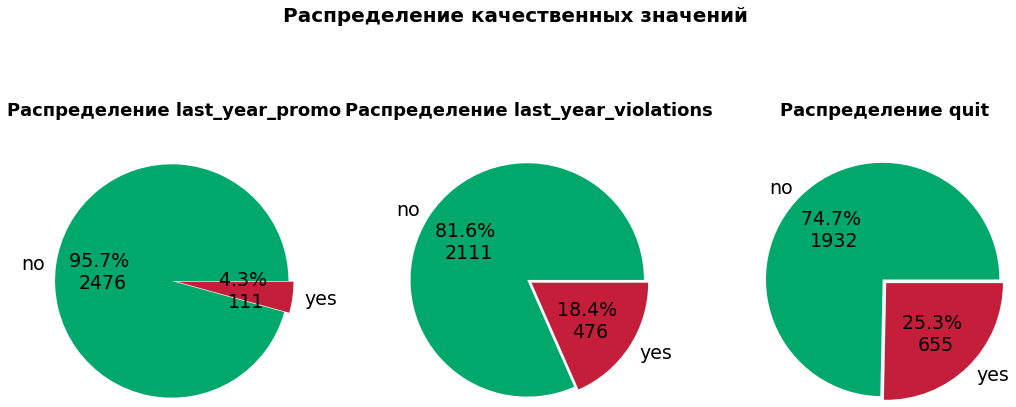

In [62]:
cat_features_1 = list(cat_features.copy())
cat_features_1.append('quit')

fig, ax = plt.subplots(1, len(cat_features_1[3:]), figsize=(15, 8))
fig.suptitle('Распределение качественных значений', size=20, weight='bold')
plt.subplots_adjust(wspace=1.8)
colors = ['#00A86B', '#C41E3A']

for ind, column in enumerate(cat_features_1[3:]):
    table = train_quit[column].value_counts()
    wedges, texts, autotexts = ax[ind].pie(table, autopct=lambda pct: percent(pct, table), 
                                           colors=colors, radius=2.3, labels=table.index, 
                                           explode=[0.05 for i in range(len(table.index))])
    plt.setp(autotexts, size=19)
    plt.setp(texts, size=19)
    ax[ind].set_title(f'Распределение {column}', y=1.8, pad=1, fontsize=18, weight='bold')

plt.show()

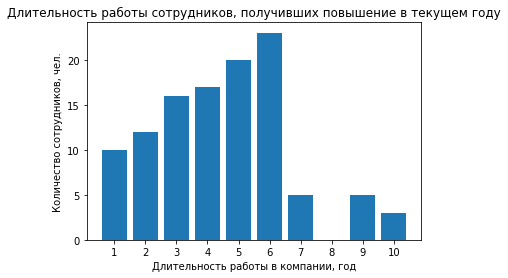

In [63]:
promo = train_quit[train_quit['last_year_promo'] == 'yes']

table = promo['employment_years'].value_counts()
plt.bar(table.index, table.values)
plt.title(f'Длительность работы сотрудников, получивших повышение в текущем году')
plt.ylabel('Количество сотрудников, чел.')
plt.xlabel('Длительность работы в компании, год')
plt.xticks(range(1, 11))

plt.show()

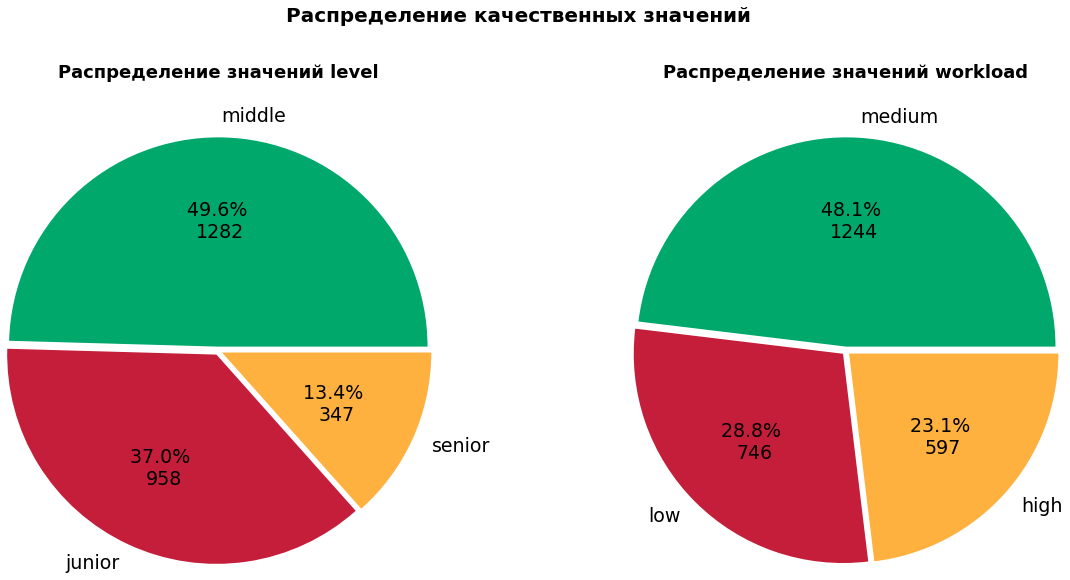

In [64]:
fig, ax = plt.subplots(1, len(cat_features[1:3]), figsize=(15, 10))
fig.suptitle('Распределение качественных значений', size=20, weight='bold')
plt.subplots_adjust(wspace=2)
colors = ['#00A86B', '#C41E3A', '#FFB140']

for ind, column in enumerate(cat_features[1:3]):
    table = train_quit[column].value_counts()
    wedges, texts, autotexts = ax[ind].pie(table, autopct=lambda pct: percent(pct, table), 
                                           colors=colors, radius=2.5, labels=table.index, 
                                           explode=[0.05 for i in range(len(table.index))])
    plt.setp(autotexts, size=19)
    plt.setp(texts, size=19)
    ax[ind].set_title(f'Распределение значений {column}', y=1.8, pad=1, fontsize=18, weight='bold')

plt.show()

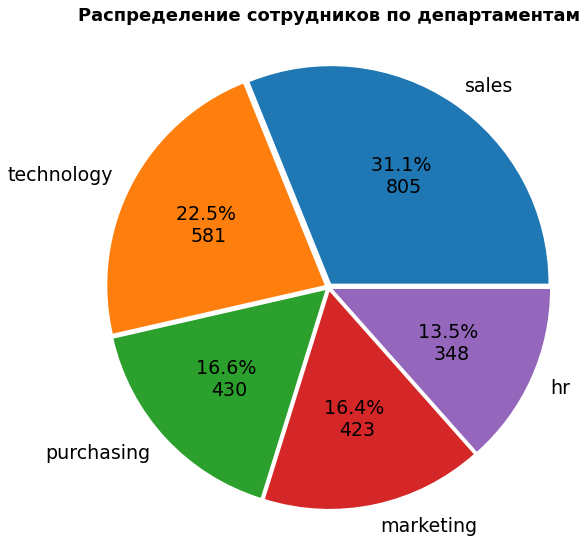

In [65]:
table = train_quit[cat_features[0]].value_counts()
wedges, texts, autotexts = plt.pie(table, autopct=lambda pct: percent(pct, table), 
                                   radius=2.5, labels=table.index, 
                                   explode=[0.05 for i in range(len(table.index))])
plt.setp(autotexts, size=19)
plt.setp(texts, size=19)
plt.title('Распределение сотрудников по департаментам', y=1.7, fontsize=18, weight='bold')
    

plt.show()

Выводы по графикам **качественных признаков**:
- В целевом признаке `quit` наблюдается дисбаланс меток. Только 25% уволилось в текущем году; 
- Во входном признаке `last_year_promo` наблюдается значительный дисбаланс меток. Только 4% сотрудников получали повышение за последний год;
- Во входном признаке `last_year_violations` наблюдается значительный дисбаланс меток. 18% сотрудников нарушали трудовой договор за последний год;
- Во входном признаке `level` всего лишь 13% senior, midle и junior - 50% и 37% соответственно;
- Во входном признаке `workload` загруженность распределена следующим образом: low - 29%, medium - 48%, high - 23%;
- Во входном признаке `dept` большая часть сотрудников работает в отделе продаж (31%), и технологии (23%), в остальных отделах 13-17% в каждом.

#### Визуализация качественных значений датафрейма `data_test`

In [66]:
display(cat_features)

Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object')

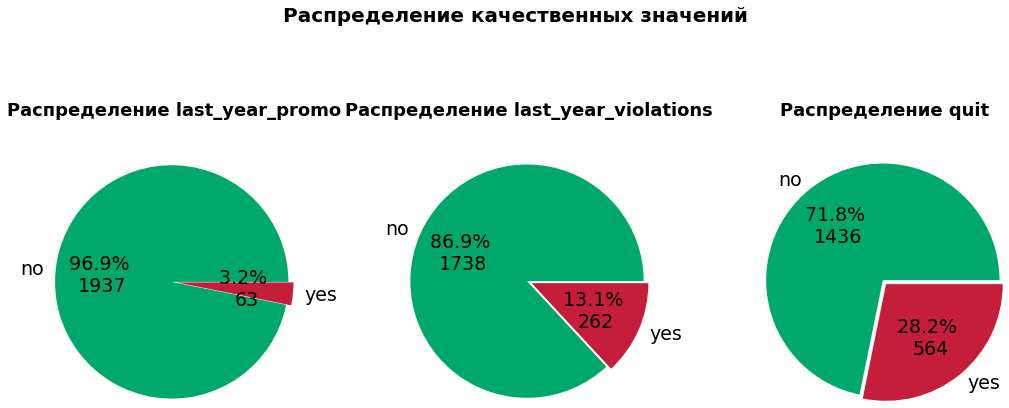

In [67]:
fig, ax = plt.subplots(1, len(cat_features_1[3:]), figsize=(15, 8))
fig.suptitle('Распределение качественных значений', size=20, weight='bold')
plt.subplots_adjust(wspace=1.8)
colors = ['#00A86B', '#C41E3A']

for ind, column in enumerate(cat_features_1[3:]):
    table = data_test[column].value_counts()
    wedges, texts, autotexts = ax[ind].pie(table, autopct=lambda pct: percent(pct, table), 
                                           colors=colors, radius=2.3, labels=table.index, 
                                           explode=[0.05 for i in range(len(table.index))])
    plt.setp(autotexts, size=19)
    plt.setp(texts, size=19)
    ax[ind].set_title(f'Распределение {column}', y=1.8, pad=1, fontsize=18, weight='bold')

plt.show()

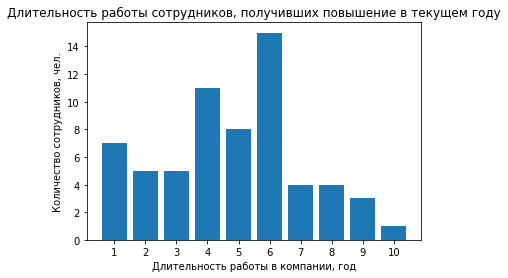

In [68]:
promo = data_test[data_test['last_year_promo'] == 'yes']

table = promo['employment_years'].value_counts()
plt.bar(table.index, table.values)
plt.title(f'Длительность работы сотрудников, получивших повышение в текущем году')
plt.ylabel('Количество сотрудников, чел.')
plt.xlabel('Длительность работы в компании, год')
plt.xticks(range(1, 11))

plt.show()

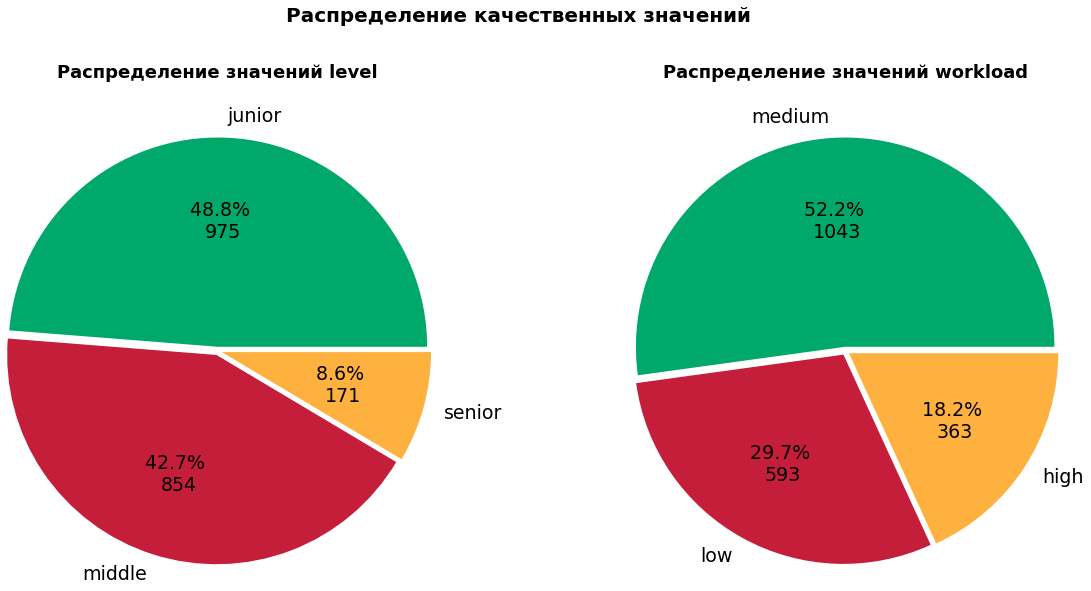

In [69]:
fig, ax = plt.subplots(1, len(cat_features[1:3]), figsize=(15, 10))
fig.suptitle('Распределение качественных значений', size=20, weight='bold')
plt.subplots_adjust(wspace=2)
colors = ['#00A86B', '#C41E3A', '#FFB140']

for ind, column in enumerate(cat_features[1:3]):
    table = data_test[column].value_counts()
    wedges, texts, autotexts = ax[ind].pie(table, autopct=lambda pct: percent(pct, table), 
                                           colors=colors, radius=2.5, labels=table.index, 
                                           explode=[0.05 for i in range(len(table.index))])
    plt.setp(autotexts, size=19)
    plt.setp(texts, size=19)
    ax[ind].set_title(f'Распределение значений {column}', y=1.8, pad=1, fontsize=18, weight='bold')

plt.show()

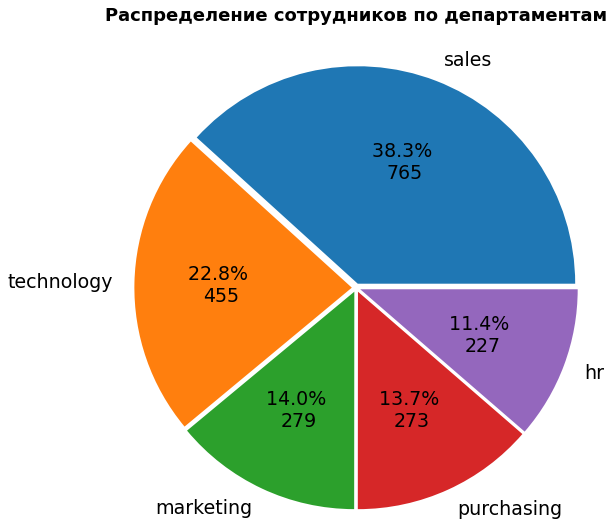

In [70]:
table = data_test[cat_features[0]].value_counts()
wedges, texts, autotexts = plt.pie(table, autopct=lambda pct: percent(pct, table), 
                                   radius=2.5, labels=table.index, 
                                   explode=[0.05 for i in range(len(table.index))])
plt.setp(autotexts, size=19)
plt.setp(texts, size=19)
plt.title('Распределение сотрудников по департаментам', y=1.7, fontsize=18, weight='bold')
    

plt.show()

Выводы по графикам **качественных признаков**:
- В целевом признаке `quit` наблюдается дисбаланс меток. Только 28% уволилось в текущем году; 
- Во входном признаке `last_year_promo` наблюдается значительный дисбаланс меток. Только 3% сотрудников получали повышение за последний год;
- Во входном признаке `last_year_violations` наблюдается значительный дисбаланс меток. 13% сотрудников нарушали трудовой договор за последний год;
- Во входном признаке `level` всего лишь 9% senior, midle и junior - 42% и 49% соответственно;
- Во входном признаке `workload` загруженность распределена следующим образом: low - 30%, medium - 52%, high - 18%;
- Во входном признаке `dept` большая часть сотрудников работает в отделе продаж (38%), и технологии (23%), в остальных отделах 11-15 % в каждом.

### Вывод по разделу 

- Уровень зарплат рассматриваемых датафреймов принадлежит одной генеральной совокупности;
- Распределение количественных и качественных признаков примерно одинаковое у рассматриваемых датафреймов;
- Значения в столбце `job_satisfaction_rate` имеют вид, приближенный к нормальному распределению;
- Значения в столбце `salary` имеют вид, приближенный к гамма распределению;
- Значения в столбце `employment_years` имеют вид, приближенный к гамма распределению;
- Значения в столбце `supervisor_evaluation` имеют вид, приближенный к бета распределению;
- В целевом признаке `quit` наблюдается дисбаланс меток. Только 25-28% уволилось в текущем году; 
- Во входном признаке `last_year_promo` наблюдается значительный дисбаланс меток. Только 3-4% сотрудников получали повышение за последний год;
- Во входном признаке `last_year_violations` наблюдается значительный дисбаланс меток. 14-18% сотрудников нарушали трудовой договор за последний год;
- Во входном признаке `level` всего лишь 9-13% senior, midle и junior - 42-50% и 37-49% соответственно;
- Во входном признаке `workload` загруженность распределена следующим образом: low - 29-30%, medium - 48-53%, high - 17-23%;
- Во входном признаке `dept` большая часть сотрудников работает в отделе продаж (31-38%), и технологии (22-23%), в остальных отделах 11-17 % в каждом.

### Портрет "уволившегося сотрудника" и его уровень удовлетворенности работой

Для проведения аналитической работы будем работать с датафреймом `data_test`

In [71]:
retired = data_test.query('quit == "yes"')
still_here = data_test.query('quit == "no"')

#### Оценка влияния срока работы в компании

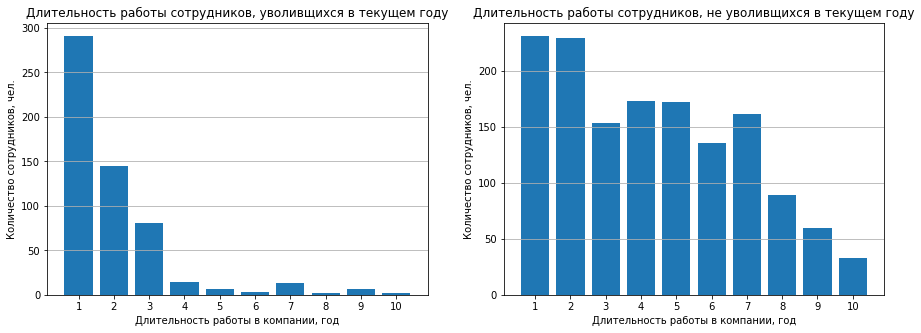

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

table_r = retired['employment_years'].value_counts()
table_s = still_here['employment_years'].value_counts()

ax[0].bar(table_r.index, table_r.values)
ax[0].set_title('Длительность работы сотрудников, уволивщихся в текущем году')
ax[0].set_ylabel('Количество сотрудников, чел.')
ax[0].set_xlabel('Длительность работы в компании, год')
ax[0].set_xticks(range(1, 11))
ax[0].grid(axis='y')

ax[1].bar(table_s.index, table_s.values)
ax[1].set_title('Длительность работы сотрудников, не уволивщихся в текущем году')
ax[1].set_ylabel('Количество сотрудников, чел.')
ax[1].set_xlabel('Длительность работы в компании, год')
ax[1].set_xticks(range(1, 11))
ax[1].grid(axis='y')

plt.show()

Большая часть сотрудников, которая **уволилась** в этом году отработали в компании **менее 4 лет**.

#### Оценка влияния признаков повышения сотрудников и нарушения трудового договора 

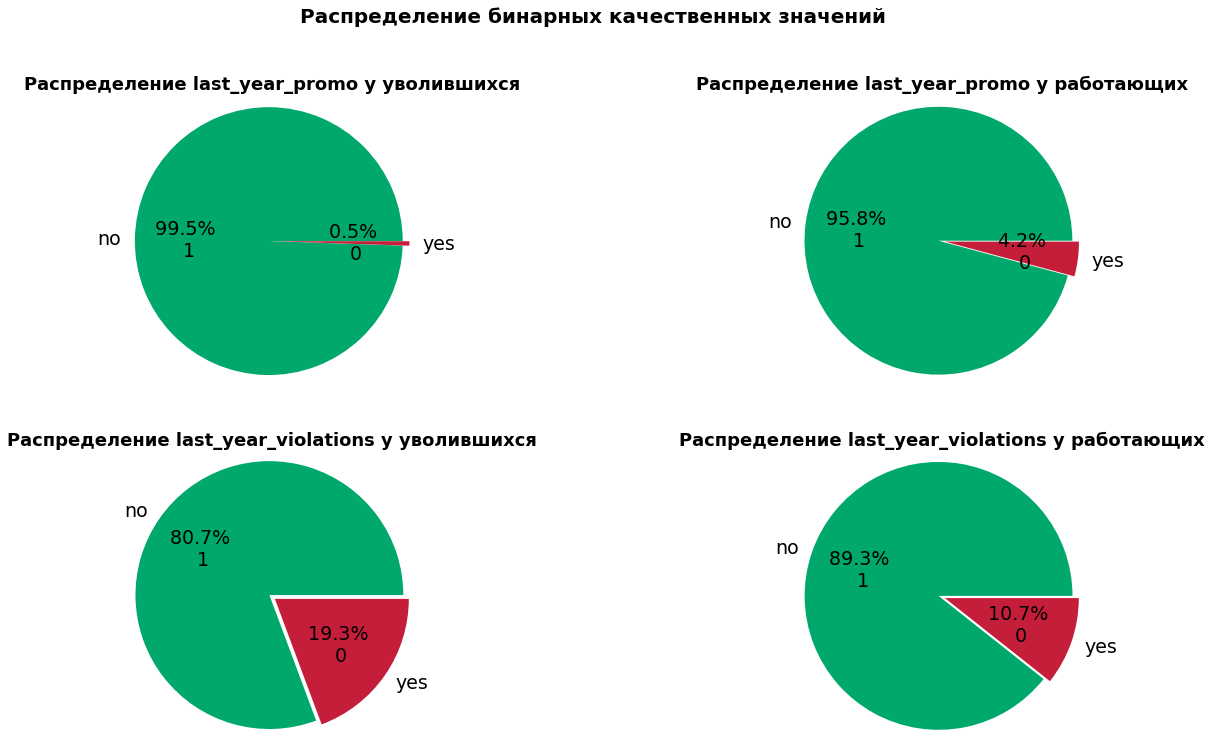

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Распределение бинарных качественных значений', size=20, weight='bold')
plt.subplots_adjust(wspace=3)
colors = ['#00A86B', '#C41E3A']

i = 0
for column in cat_features_1[3:5]:
    for j in range(2):
        if j == 0:
            table = retired[column].value_counts(normalize=True)
        else:
            table = still_here[column].value_counts(normalize=True)
        
        wedges, texts, autotexts = ax[i, j].pie(table, autopct=lambda pct: percent(pct, table), 
                                                colors=colors, radius=2, labels=table.index, 
                                                explode=[0.05 for i in range(len(table.index))])
        plt.setp(autotexts, size=19)
        plt.setp(texts, size=19)
        if j == 0:
            ax[i, j].set_title(f'Распределение {column} у уволившихся', y=1.4, pad=1, 
                               fontsize=18, weight='bold')
        else:
            ax[i, j].set_title(f'Распределение {column} у работающих', y=1.4, pad=1, 
                               fontsize=18, weight='bold') 
    i += 1

plt.show()

**Количество** сотрудников, **получивших повышение**, в группе уволившихся **меньше на 3,5%**, чем в группе работающих. **Количество** сотрудников, **нарушавших трудовой договор**, в группе уволившихся **больше на 8,6%**, чем в группе работающих.

#### Оценка влияния признаков уровня загрузки и уровня занимаемой должности

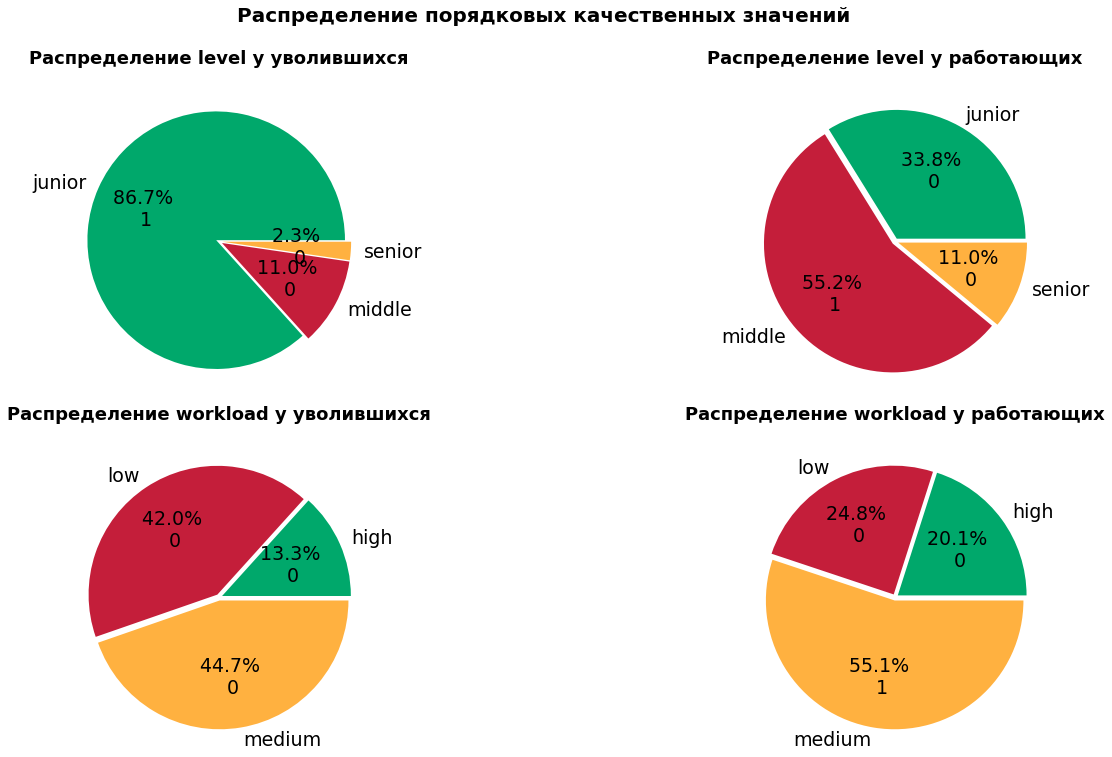

In [74]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Распределение порядковых качественных значений', size=20, weight='bold')
plt.subplots_adjust(wspace=3.2)
colors = ['#00A86B', '#C41E3A', '#FFB140']

i = 0
for column in cat_features_1[1:3]:
    for j in range(2):
        if j == 0:
            table = retired[column].value_counts(normalize=True).sort_index()
        else:
            table = still_here[column].value_counts(normalize=True).sort_index()
        
        wedges, texts, autotexts = ax[i, j].pie(table, autopct=lambda pct: percent(pct, table), 
                                                colors=colors, radius=2, labels=table.index, 
                                                explode=[0.05 for i in range(len(table.index))])
        plt.setp(autotexts, size=19)
        plt.setp(texts, size=19)
        if j == 0:
            ax[i, j].set_title(f'Распределение {column} у уволившихся', y=1.6, pad=1, 
                               fontsize=18, weight='bold')
        else:
            ax[i, j].set_title(f'Распределение {column} у работающих', y=1.6, pad=1, 
                               fontsize=18, weight='bold') 
    i += 1

plt.show()

Большая часть уволившихся сотрудников занимали должность **junior** и имели **малый уровень нагрузки**.

#### Оценка влияния уровня заработных плат и удовлетворенности работой 

'Показатели уволившихся сотрудников'

,salary,job_satisfaction_rate
count,564.000000,564.000000
mean,24955.319149,0.387713
std,10650.300744,0.185784
min,12000.000000,0.040000
25%,18000.000000,0.240000
50%,22800.000000,0.370000
75%,30000.000000,0.492500
max,80400.000000,0.970000


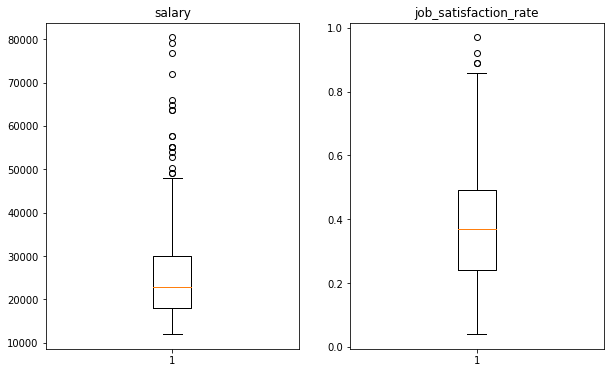

'Показатели работающих сотрудников'

,salary,job_satisfaction_rate
count,1436.000000,1436.000000
mean,37645.403900,0.612040
std,15503.475156,0.199367
min,12000.000000,0.030000
25%,25200.000000,0.500000
50%,33600.000000,0.660000
75%,48000.000000,0.760000
max,96000.000000,1.000000


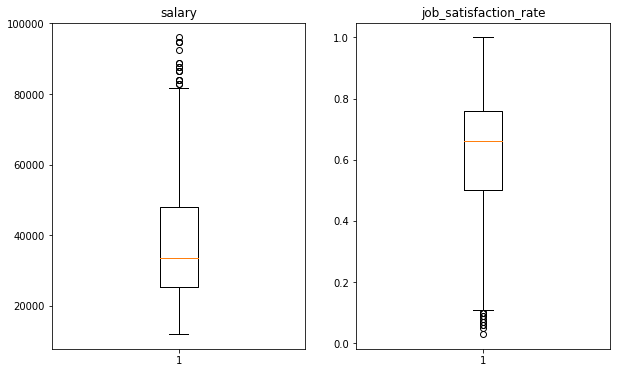

In [75]:
display('Показатели уволившихся сотрудников', retired[num_cont_features].describe())

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

for i, col in enumerate(num_cont_features):
    ax[i].boxplot(retired[col])
    ax[i].set_title(col)
    
plt.show()

display('Показатели работающих сотрудников', still_here[num_cont_features].describe())
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

for i, col in enumerate(num_cont_features):
    ax[i].boxplot(still_here[col])
    ax[i].set_title(col)
    
plt.show()

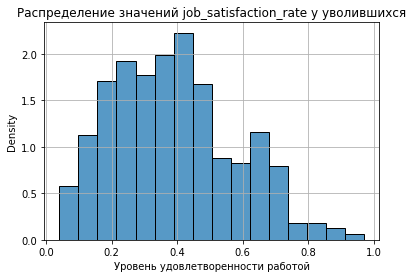

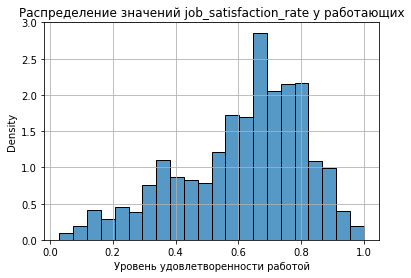

In [76]:
sns.histplot(retired['job_satisfaction_rate'], stat='density', common_norm=False)
plt.title('Распределение значений job_satisfaction_rate у уволившихся')
plt.xlabel('Уровень удовлетворенности работой')
plt.grid()
plt.show()

sns.histplot(still_here['job_satisfaction_rate'], stat='density', common_norm=False)
plt.title('Распределение значений job_satisfaction_rate у работающих')
plt.xlabel('Уровень удовлетворенности работой')
plt.grid()
plt.show()

Уровень зарплат и удовлетворенность работой двух групп сильно различаются:
1. Большая часть **уровня зарплат уволившихся** сотрудников лежит в диапозоне **18 000-30 000**, а **работающих** сотрудников **25 200-48 000**. Медианные значения отличаются на **47%** (22 800 против 33 600);
2. Большая часть **уровня удовлетворенности уволившихся** сотрудников лежит в диапозоне **0.24-0.49**, а **работающих** сотрудников **0.50-0.76**. Медианные значения отличаются на **78%** (0.37 против 0.66).

#### Оценка влияние департамента

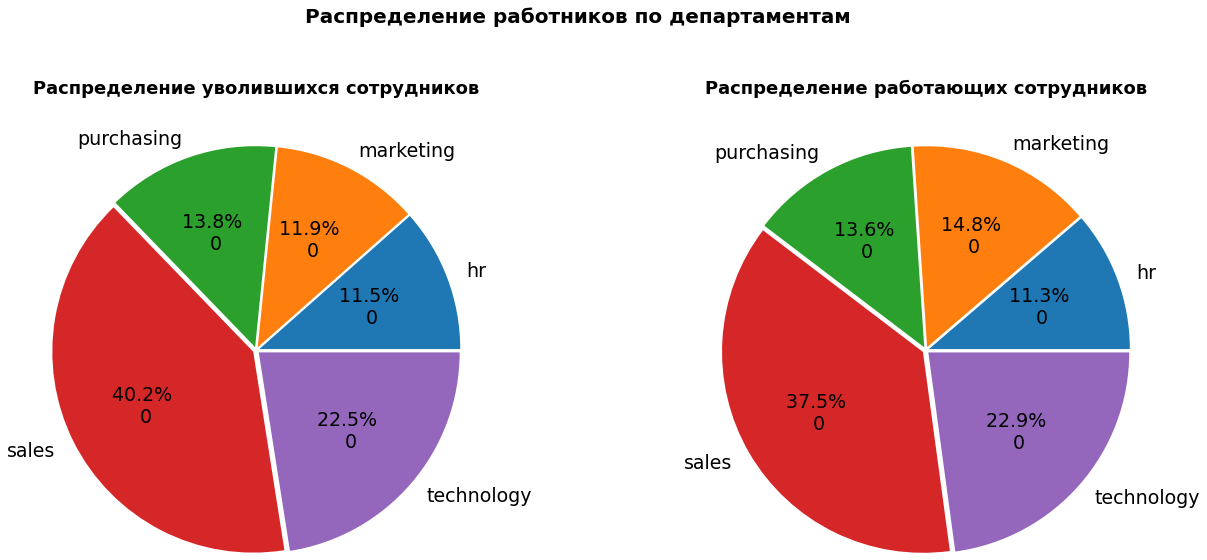

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
fig.suptitle('Распределение работников по департаментам', size=20, weight='bold')
plt.subplots_adjust(wspace=3)

table_r = retired['dept'].value_counts(normalize=True).sort_index()
table_s = still_here['dept'].value_counts(normalize=True).sort_index()
wedges, texts, autotexts = ax[0].pie(table_r, autopct=lambda pct: percent(pct, table_r), 
                                     radius=3, labels=table_r.index, 
                                     explode=[0.05 for i in range(len(table_r.index))])
plt.setp(autotexts, size=19)
plt.setp(texts, size=19)
ax[0].set_title('Распределение уволившихся сотрудников', y=2, fontsize=18, weight='bold')

wedges, texts, autotexts = ax[1].pie(table_s, autopct=lambda pct: percent(pct, table_s), 
                                     radius=3, labels=table_s.index, 
                                     explode=[0.05 for i in range(len(table_s.index))])
plt.setp(autotexts, size=19)
plt.setp(texts, size=19)
ax[1].set_title('Распределение работающих сотрудников', y=2, fontsize=18, weight='bold')

plt.show()

Есть небольшие различия в части департаментов у уволившихся сотрудников и работающих. Так например, в отделе **продаж** и **маркетинга** **текучка больше на 3%**, чем в остальных департаментах.

#### Формирование комлпексного портрета

На основании проведено анализа можно сформировать **портрет "уволившегося сотрудника"**:
1. Большая часть сотрудников, которая уволилась в этом году отработали в компании менее 4 лет;
2. Количество уволившихся сотрудников, **получивших повышение в текущем году**, меньше на 3,5%, чем в группе работающих; 
3. Количество уволившихся сотрудников, **нарушавших трудовой договор**, больше на 8,6%, чем в группе работающих;
4. Большая часть уволившихся сотрудников занимали должность **junior** и имели **малый уровень нагрузки**;
5. В среднем (*медиана*) уволившиеся сотрудники имели **уровень заработной платы ниже на 47%**, чем у работающих;
6. В среднем (*медиана*) уволившиеся сотрудники имели **уровень удовлетворенности работой ниже на 78%**, чем у работающих. 

## Корреляционный анализ

### Определение корреляции между признаками 

#### Построение корреляционной матрицы датафрейма `train_job_satisfaction_rate`

In [78]:
display(train_job_satisfaction_rate.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


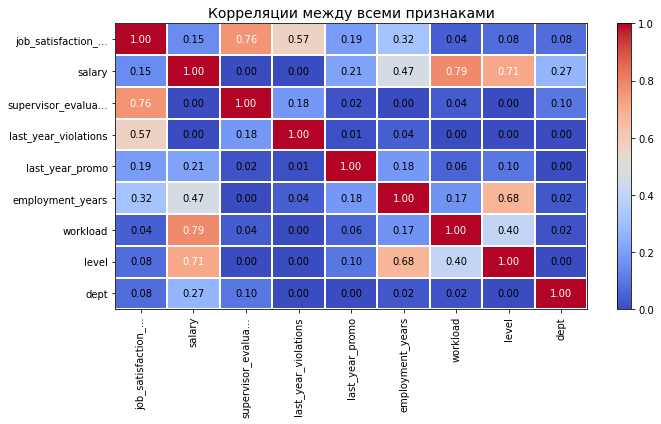

In [79]:
correlation_matrix = train_job_satisfaction_rate.phik_matrix(interval_cols=num_cont_features)

plot_correlation_matrix(correlation_matrix.values, 
                        x_labels=correlation_matrix.columns, 
                        y_labels=correlation_matrix.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title='Корреляции между всеми признаками', 
                        fontsize_factor=1, 
                        figsize=(10, 6))
plt.tight_layout()

В процессе проведения корреляционного анализа была обнаружена **взаимосвязь** следующих входных признаков:
- Высокая прямая линейная корреляция (**0,79**) признака `workload` и `salary`;
- Высокая прямая линейная корреляция (**0,71**) признака `level` и `salary`;
- Заметная прямая линейная корреляция (**0,68**) признака `level` и `employment_years`.

Была обнаружена следующая **взаимосвязь** между целевым признаком **`job_satisfaction_rate`** и входными:
- Высокая прямая линейная корреляция (**0,76**) с признаком `supervisor_evaluation`;
- Заметная прямая линейная корреляция (**0,57**) с признаком `last_year_violations`.

#### Построение корреляционной матрицы датафрейма `train_quit`

In [80]:
display(train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


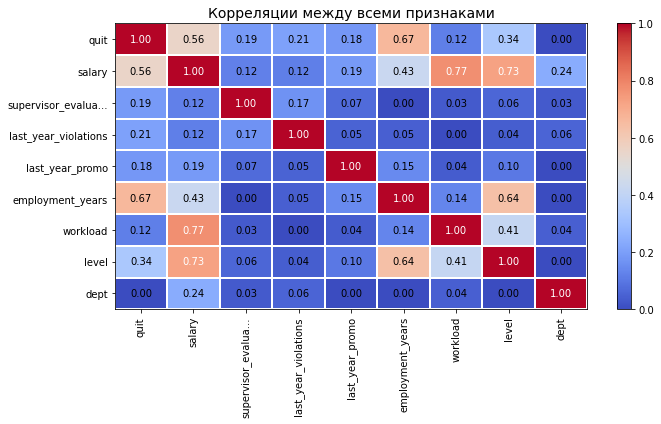

In [81]:
correlation_matrix = train_quit.phik_matrix(interval_cols=['salary'])

plot_correlation_matrix(correlation_matrix.values, 
                        x_labels=correlation_matrix.columns, 
                        y_labels=correlation_matrix.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title='Корреляции между всеми признаками', 
                        fontsize_factor=1, 
                        figsize=(10, 6))
plt.tight_layout()

Взаимосвязь между входными признаками соответствует взаимосвязи, обнаруженной в датайрейме `train_job_satisfaction_rate`.

Была обнаружена следующая **взаимосвязь** между целевым признаком **`quit`** и входными:
- Заметная прямая линейная корреляция (**0,67**) с признаком `employment_years`;
- Заметная прямая линейная корреляция (**0,56**) с признаком `salary`.

#### Построение корреляционной матрицы датафрейма `train_quit`

In [82]:
display(data_test.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,hr,junior,medium,1,no,no,4,30000,0.72,no
2,sales,middle,low,5,no,no,4,19200,0.64,no
3,sales,middle,low,6,no,no,4,19200,0.60,no
4,hr,middle,medium,5,no,no,5,40800,0.75,no


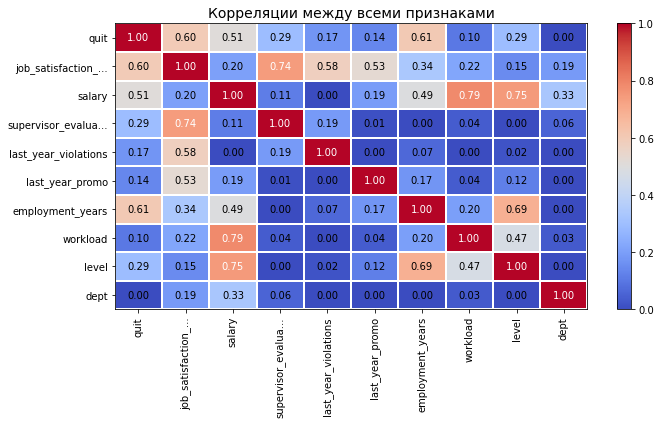

In [83]:
correlation_matrix = data_test.phik_matrix(interval_cols=['salary'])

plot_correlation_matrix(correlation_matrix.values, 
                        x_labels=correlation_matrix.columns, 
                        y_labels=correlation_matrix.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title='Корреляции между всеми признаками', 
                        fontsize_factor=1, 
                        figsize=(10, 6))
plt.tight_layout()

Взаимосвязи между входными признакими и между входными признаками и целевыми соответствует ранее обнаруженным в датафреймах `train_job_satisfaction_rate` и `train_quit`.

Дополнительно было обнаружена заметная прямая корреляция между целевыми признаками (**0,60**) `quit` и `job_satisfaction_rate`.

### Построение диаграмм рассеивания и графиков "ящик с усами" по признакам

#### Построение диаграмм рассеивания датафрейма `train_job_satisfaction_rate`

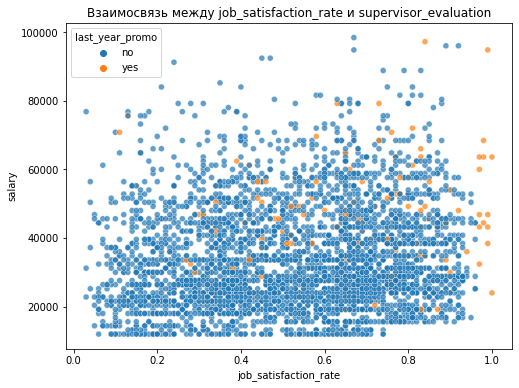

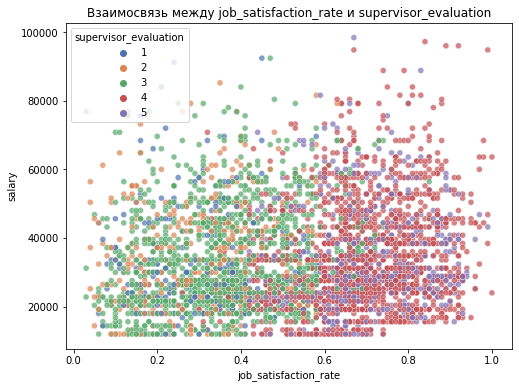

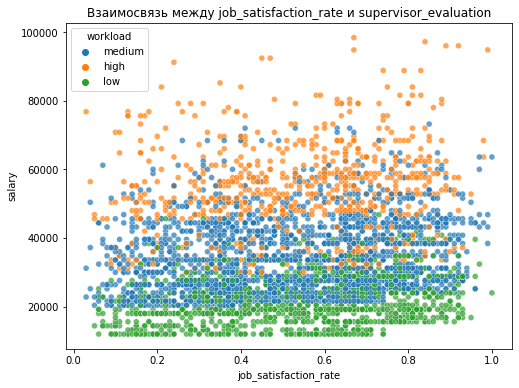

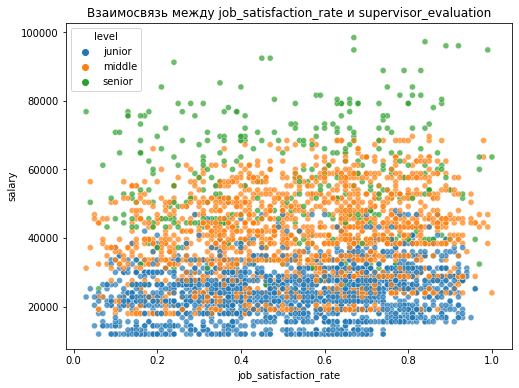

In [84]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_job_satisfaction_rate, x='job_satisfaction_rate', y='salary',
               hue='last_year_promo', alpha=0.7)
plt.title('Взаимосвязь между job_satisfaction_rate и supervisor_evaluation')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_job_satisfaction_rate, x='job_satisfaction_rate', y='salary',
               hue='supervisor_evaluation', alpha=0.7, palette='deep')
plt.title('Взаимосвязь между job_satisfaction_rate и supervisor_evaluation')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_job_satisfaction_rate, x='job_satisfaction_rate', y='salary',
               hue='workload', alpha=0.7)
plt.title('Взаимосвязь между job_satisfaction_rate и supervisor_evaluation')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_job_satisfaction_rate, x='job_satisfaction_rate', y='salary',
               hue='level', alpha=0.7)
plt.title('Взаимосвязь между job_satisfaction_rate и supervisor_evaluation')
plt.show()

#### Построение графиков "ящик с усами" датафрейма `train_job_satisfaction_rate `

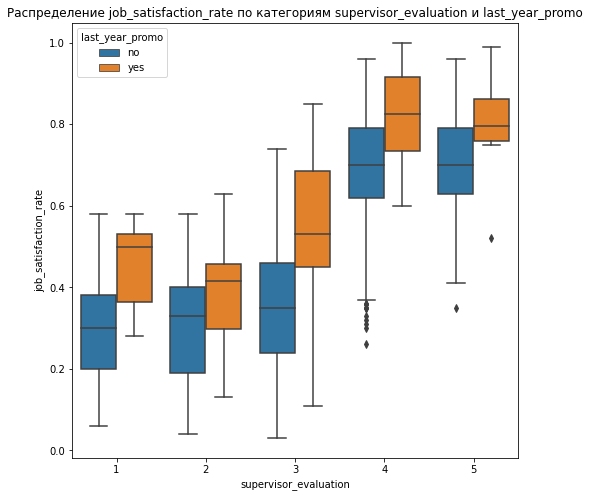

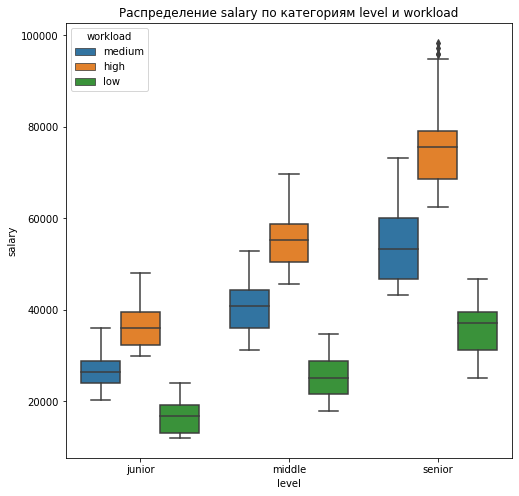

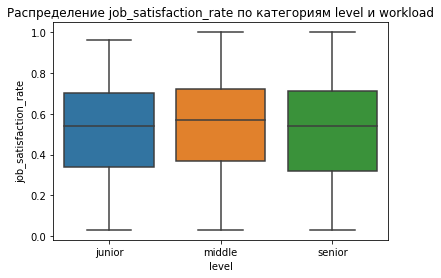

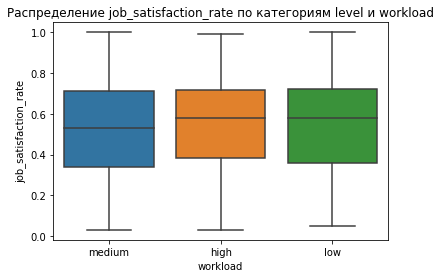

In [85]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=train_job_satisfaction_rate, x='supervisor_evaluation', y='job_satisfaction_rate', 
            hue='last_year_promo')
plt.title('Распределение job_satisfaction_rate по категориям supervisor_evaluation и last_year_promo')
plt.show()

plt.figure(figsize=(8, 8))
sns.boxplot(data=train_job_satisfaction_rate, x='level', y='salary', hue='workload')
plt.title('Распределение salary по категориям level и workload')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=train_job_satisfaction_rate, x='level', y='job_satisfaction_rate')
plt.title('Распределение job_satisfaction_rate по категориям level и workload')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=train_job_satisfaction_rate, x='workload', y='job_satisfaction_rate')
plt.title('Распределение job_satisfaction_rate по категориям level и workload')
plt.show()

#### Построение диаграмм рассеивания датафрейма `train_quit`

В связи с тем, что корреляция между входными признаками датафрейма соответствует корреляции между входными признаками датафрейма `train_job_satisfaction_rate`, в данном подпункте будет рассматриваться зависимости между целевым признаком `quit` и входными.

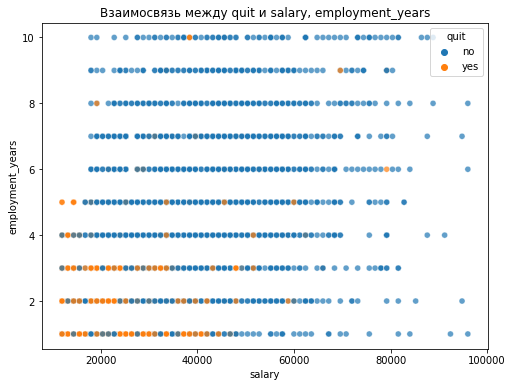

In [86]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_quit, x='salary', y='employment_years',
               hue='quit', alpha=0.7)
plt.title('Взаимосвязь между quit и salary, employment_years')
plt.show()

#### Построение графиков "ящик с усами" датафрейма `train_quit `

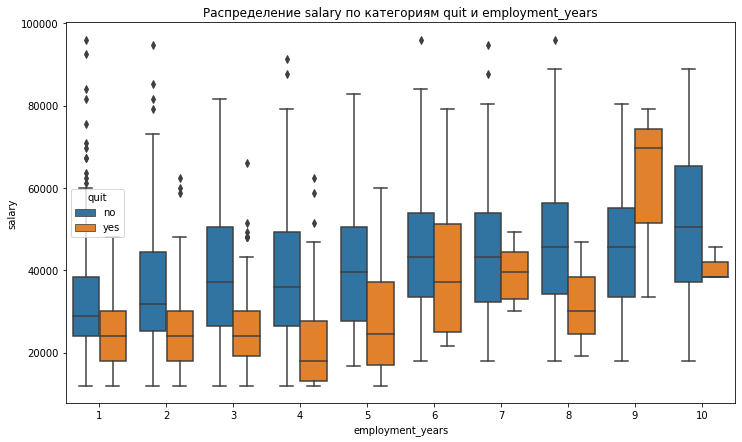

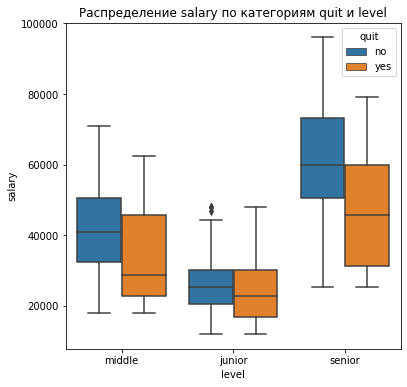

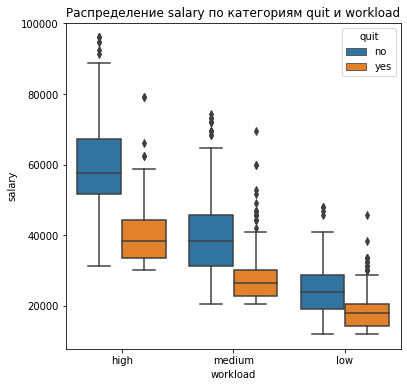

In [87]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=train_quit, x='employment_years', y='salary', 
            hue='quit')
plt.title('Распределение salary по категориям quit и employment_years')
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(data=train_quit, x='level', y='salary', 
            hue='quit')
plt.title('Распределение salary по категориям quit и level')
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(data=train_quit, x='workload', y='salary', 
            hue='quit')
plt.title('Распределение salary по категориям quit и workload')
plt.show()

#### Построение диаграмм рассеивания датафрейма `data_test`

В данном подпункте будет рассматриваться зависимости между целевыми признаками `quit` и `job_satisfaction_rate`.

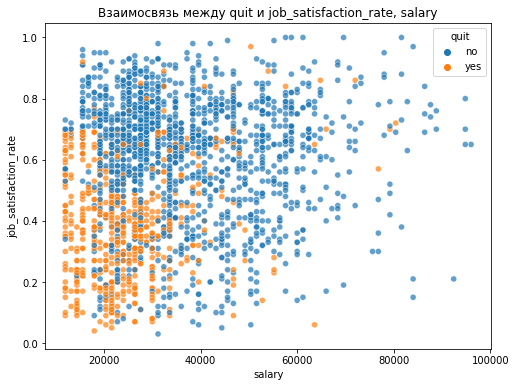

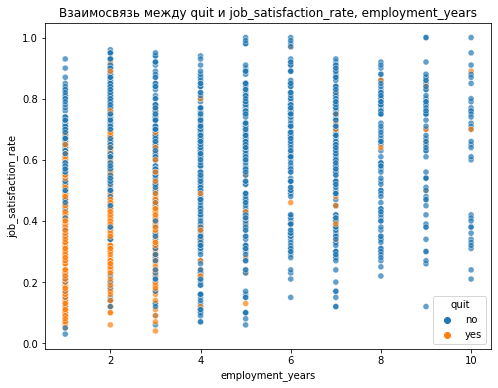

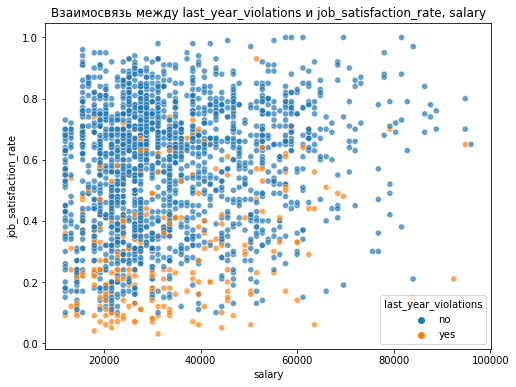

In [88]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_test, x='salary', y='job_satisfaction_rate',
               hue='quit', alpha=0.7)
plt.title('Взаимосвязь между quit и job_satisfaction_rate, salary')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_test, x='employment_years', y='job_satisfaction_rate',
               hue='quit', alpha=0.7)
plt.title('Взаимосвязь между quit и job_satisfaction_rate, employment_years')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_test, x='salary', y='job_satisfaction_rate',
               hue='last_year_violations', alpha=0.7)
plt.title('Взаимосвязь между last_year_violations и job_satisfaction_rate, salary')
plt.show()

#### Построение графиков "ящик с усами" датафрейма `data_test `

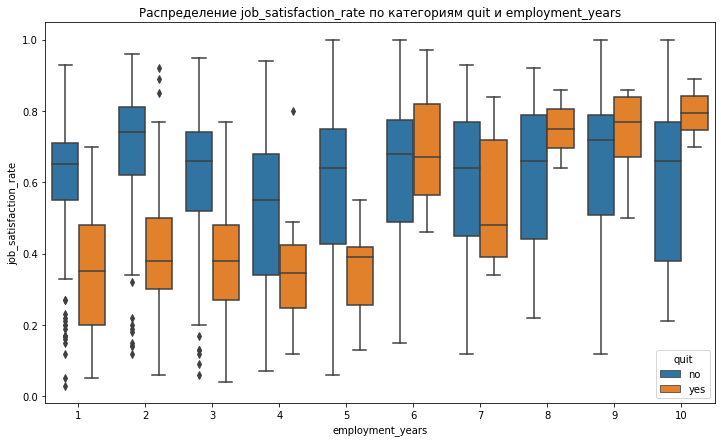

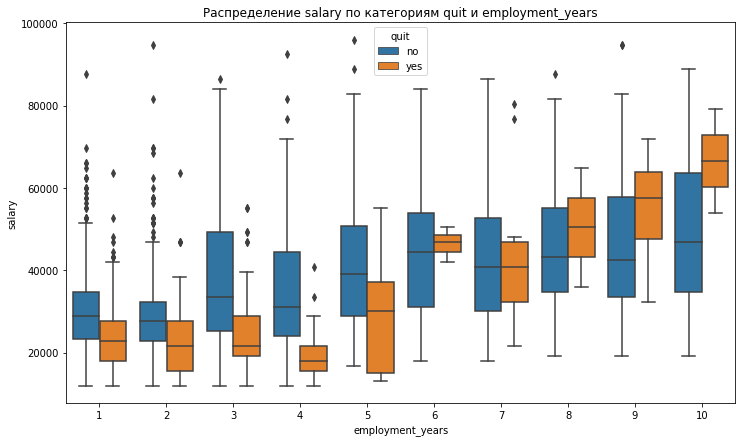

In [89]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=data_test, x='employment_years', y='job_satisfaction_rate', 
            hue='quit')
plt.title('Распределение job_satisfaction_rate по категориям quit и employment_years')
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(data=data_test, x='employment_years', y='salary', 
            hue='quit')
plt.title('Распределение salary по категориям quit и employment_years')
plt.show()


### Вывод по разделу

В процессе проведения корреляционного анализа была обнаружена **взаимосвязь** следующих входных признаков:
- Высокая прямая линейная корреляция (**0.77-0.79**) признака `workload` и `salary`;
- Высокая прямая линейная корреляция (**0.71-0.75**) признака `level` и `salary`;
- Заметная прямая линейная корреляция (**0.64-0.69**) признака `level` и `employment_years`.

Была обнаружена следующая **взаимосвязь** между целевым признаком **`job_satisfaction_rate`** и входными:
- Высокая прямая линейная корреляция (**0.74**) с признаком `supervisor_evaluation`;
- Заметная прямая линейная корреляция (**0.57-0.58**) с признаком `last_year_violations`.

Была обнаружена следующая **взаимосвязь** между целевым признаком **`quit`** и входными:
- Заметная прямая линейная корреляция (**0.61-0.67**) с признаком `employment_years`;
- Заметная прямая линейная корреляция (**0.51-0.56**) с признаком `salary`.

Была обнаружена **заметная взаимосвязь (0.60)** между целевыми признаками **`quit`** и **`job_satisfaction_rate`**.

Стоит отметить, что **мультиколлинеарности** в данных нет. Коррелирующие между собой признаки связано логически обосновано.

## Обучение моделей МО. Предсказание уровня удовлетворённости сотрудника

In [90]:
def smape_score(y_true, y_pred):
    num = abs(y_pred - y_true)
    denom = (abs(y_pred) + abs(y_true)) / 2
    total = (num / denom).sum()
    return abs(total * 100 / y_true.shape[0])

In [91]:
smape = make_scorer(smape_score, greater_is_better=False)

In [92]:
data_sat = train_job_satisfaction_rate.copy()
data_sat = data_sat.reset_index(drop=True)

### Подготовка пайплайна

In [93]:
RANDOM_STATE = 7
TEST_SIZE = 0.25

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary', 'supervisor_evaluation']

In [94]:
lev = list(data_sat['level'].unique())
work = list(data_sat['workload'].unique())

ohe_pipe = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                           ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])

ordin_pipe = Pipeline(steps=[
    ('imputer_before', SimpleImputer(strategy='most_frequent', fill_value='unknown')),
    ('ordin', OrdinalEncoder(categories=[lev, work], handle_unknown='use_encoded_value', 
                             unknown_value=np.nan)),
    ('imputer_after', SimpleImputer(strategy='most_frequent', fill_value='unknown'))])

In [95]:
preprocessor = ColumnTransformer(transformers=[('ohe', ohe_pipe, ohe_columns),
                                               ('ord', ordin_pipe, ord_columns),
                                               ('num', StandardScaler(), num_columns)], 
                                 remainder='passthrough')

In [96]:
pipe_sat = Pipeline([('preprocessor', preprocessor), 
                     ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))])

### Обучение моделей

In [97]:
X_train_sat = data_sat.drop(['job_satisfaction_rate'], axis=1)
y_train_sat = data_sat['job_satisfaction_rate']

In [98]:
param_grid_sat = [{'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)], 
                   'models__max_depth': range(3, 5), 
                   'models__max_features': range(2, 5)},
                  {'models': [LinearRegression()]},
                  {'models': [SVR()], 
                   'models__C': range(46, 48),
                   'models__kernel': ['linear', 'poly','rbf']}]

In [99]:
pipe_sat.fit(X_train_sat, y_train_sat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer_before',
                                                                   SimpleImputer...
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['medium',
                                                                                               'high',
                                                                                               'low']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer_after',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years', 'salary',
                                                   'supervisor_evaluation'])])),
                ('models', DecisionTreeRegressor(random_state=7))])

In [100]:
grid_search_sat = GridSearchCV(pipe_sat, param_grid_sat, cv=5, scoring=smape, 
                               n_jobs=-1, error_score='raise')

In [101]:
grid_search_sat.fit(X_train_sat, y_train_sat)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord'...
                                        DecisionTreeRegressor(random_state=7))]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=7)],
                          'models__max_depth': range(3, 5),
                          'models__max_features': range(2, 5)},
                         {'models': [LinearRegression()]},
                         {'models': [SVR()], 'models__C': range(46, 48),
                          'models__kernel': ['linear', 'poly', 'rbf']}],
             scoring=make_scorer(smape_score, greater_is_better=False, response_method='predict'))

In [102]:
display('Лучшая модель и её параметры:', grid_search_sat.best_params_)
display('Метрика лучшей модели на кросс-валидации:', abs(grid_search_sat.best_score_))

'Лучшая модель и её параметры:'

{'models': SVR(), 'models__C': 46, 'models__kernel': 'rbf'}

'Метрика лучшей модели на кросс-валидации:'

15.604412578237476

Оценка качества модели на тестовых данных

In [103]:
X_test_sat = data_test.drop(columns=['job_satisfaction_rate', 'quit'])
y_test_sat = data_test['job_satisfaction_rate']

In [104]:
y_pred_sat = grid_search_sat.best_estimator_.predict(X_test_sat)
display(smape_score(y_test_sat, y_pred_sat))

14.002472197813248

### Вывод по разделу

В процессе обучения модели и предсказания таргета были выполнены следующие шаги:
1. Подготовлен пайплайн по обработке данных;
2. Совершен подбор гиперпараметров моделей МО с помощью RandomizedSearchCV. В качестве моделей были предложены `LinearRegression`, `DecisionTreeRegressor` и `SVR`. Для оценки качества модели использовалась пользовательская метрика `SMAPE`;
3. По результатам подбора была выбрана следующая модель: `SVR(C=46, kernel='rbf')`.

Значения метрики качества на тренировочной выборке - **15.6**; на тестовой выборке - **14**.

## Обучение моделей МО. Предсказание увольнения сотрудников из компании

In [105]:
data_q = train_quit.copy()
data_q = data_q.reset_index(drop=True)

In [106]:
display(data_q.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,sales,middle,high,2,no,no,4,54000,no
1,sales,junior,medium,2,no,no,4,27600,no
2,purchasing,middle,medium,5,no,no,1,37200,no
3,sales,junior,medium,2,no,yes,3,24000,yes
4,marketing,junior,medium,2,no,no,5,25200,no


In [107]:
X_train_q = data_q.drop(columns=['quit'])
y_train_q = data_q['quit']

In [108]:
X_train_q['job_satisfaction_rate'] = grid_search_sat.best_estimator_.predict(X_train_q)

In [109]:
display(X_train_q.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,0.555010
1,sales,junior,medium,2,no,no,4,27600,0.857113
2,purchasing,middle,medium,5,no,no,1,37200,0.259312
3,sales,junior,medium,2,no,yes,3,24000,0.285588
4,marketing,junior,medium,2,no,no,5,25200,0.741150


### Подготовка пайплайна

In [110]:
le = LabelEncoder()
le.fit(y_train_q)
le.classes_ = np.array(['no', 'yes'])
y_train_q = le.transform(y_train_q)

In [111]:
pipe_quit = Pipeline([('preprocessor', preprocessor), 
                       ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

### Обучение моделей

In [112]:
param_grid_quit = [{'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)], 
                    'models__max_depth': range(2, 8), 
                    'models__max_features': range(2, 8)},
                   {'models': [KNeighborsClassifier()],
                    'models__n_neighbors': range(2, 15)},
                   {'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
                    'models__C': [0.1, 0.5, 1, 10, 100],
                    'models__penalty': ['l1', 'l2'],
                    'models__solver': ['saga', 'liblinear']}, 
                   {'models': [SVC(random_state=RANDOM_STATE,probability=True)], 
                    'models__C': [0.1, 0.5, 1, 10, 100],
                    'models__kernel': ['linear', 'poly']}]

In [113]:
pipe_quit.fit(X_train_q, y_train_q)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer_before',
                                                                   SimpleImputer...
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['medium',
                                                                                               'high',
                                                                                               'low']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer_after',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years', 'salary',
                                                   'supervisor_evaluation'])])),
                ('models', DecisionTreeClassifier(random_state=7))])

In [114]:
randomized_search_quit = RandomizedSearchCV(pipe_quit, param_grid_quit, n_iter=10, 
                                            cv=5, scoring='roc_auc', 
                                            random_state=RANDOM_STATE)

In [115]:
randomized_search_quit.fit(X_train_q, y_train_q)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(step...
                                         'models__n_neighbors': range(2, 15)},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       random_state=7)],
                                         'models__C': [0.1, 0.5, 1, 10, 100],
                                         'models__penalty': ['l1', 'l2'],
                                         'models__solver': ['saga',
                                                            'liblinear']},
                                        {'models': [SVC(probability=True,
                                                        random_state=7)],
                                         'models__C': [0.1, 0.5, 1, 10, 100],
                                         'models__kernel': ['linear', 'poly']}],
                   random_state=7, scoring='roc_auc')

In [116]:
display('Лучшая модель и её параметры:', randomized_search_quit.best_params_)
display ('Метрика лучшей модели на кросс-валидации:', round(randomized_search_quit.best_score_, 3))

'Лучшая модель и её параметры:'

{'models__solver': 'liblinear',
 'models__penalty': 'l1',
 'models__C': 10,
 'models': LogisticRegression(class_weight='balanced', random_state=7)}

'Метрика лучшей модели на кросс-валидации:'

0.909

Оценка качества модели на тестовых данных

In [118]:
X_test_q = data_test.drop(columns=['quit', 'job_satisfaction_rate'])
y_test_q = data_test['quit']
y_test_q = le.transform(y_test_q)

In [119]:
X_test_q['job_satisfaction_rate'] = grid_search_sat.best_estimator_.predict(X_test_q)

In [120]:
y_pred_q = randomized_search_quit.best_estimator_.predict_proba(X_test_q)[:, 1]
score = roc_auc_score(y_test_q, y_pred_q)
display(round(score, 4))

0.9129

### Вывод по разделу

В процессе обучения модели и предсказания таргета были выполнены следующие шаги:
1. Подготовлен пайплайн по обработке данных;
2. Совершен подбор гиперпараметров моделей МО с помощью RandomizedSearchCV. В качестве моделей были предложены `LogisticRegression`, `DecisionTreeClassifier`, `KneighborsClassifier` и `SVC`. Для оценки качества модели использовалась метрика `ROC-AUC`;
3. По результатам подбора была выбрана следующая модель: `LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=10)`.

Значения метрики качества на тренировочной выборке - **0.909**; на тестовой выборке - **0.912**.

## Выводы по работе

**Цель и задачи проекта:**
- **Цель** - оптимизировать систему управления персоналом с помощью разработки моделей МО.
- **Задачи:**
1. Провести загрузку данных и знакомство с ними;
2. Провести предобработку данных;
- Обработать дубликаты и пропуски
3. Провести исследовательских анализ данных (описание и визуализацию);
- Рассмотреть распределение количественных и качественных признаков полученных датафреймов.
4. Провести корреляционный анализ (количественных и качественных признаков);
- Определить корреляцию между количественными и качественными признаками;
- Построить графики рассеивания по различным признакам;
- Построить графики "ящик с усами" по различным признакам.
5. Провести выбор и обучение модели с дальнейшим прогнозированием уровня удовлетворённости сотрудников;
- Подготовить пайплайн для обучения модели;
- Провести подбор гиперпараметров c помощью специальных функций;
- Определить лучшую модель по выбранной метрики качества.
6. Провести выбор и обучение модели с дальнейшим прогнозированием увольнения сотрудника из компании;
- Подготовить пайплайн для обучения модели;
- Провести подбор гиперпараметров c помощью специальных функций;
- Определить лучшую модель по выбранной метрики качества.

Описание исходных данных и проведенной предобработки:
- Для каждого целевого таргета получены тренировочные данные в количестве **4 000** наблюдений и тестовые данные в количестве **2 000** наблюдений;
- В датафреймах для прогнозирования уровня удовлетворенности сотрудников есть пропуски в столбцах `dept` и `level`;
- При работе с тестовыми данными необходимо сопоставить датафрейму по столбцу `id`, так как индексы не соответствуют.

Описание регламента поиска лучшей модели по прогнозированию уровня удовлетворённости сотрудников:
1. Подготовлен пайплайн по обработке данных;
2. Совершен подбор гиперпараметров моделей МО с помощью RandomizedSearchCV. В качестве моделей были предложены `LinearRegression`, `DecisionTreeRegressor` и `SVR`. Для оценки качества модели использовалась пользовательская метрика `SMAPE`;
3. По результатам подбора была выбрана следующая модель: `SVR(C=47, kernel='rbf')`.

Значения метрики качества на тренировочной выборке - **16**; на тестовой выборке - **14**.

Описание регламента поиска лучшей модели по прогнозированию увольнения сотрудника из компании:
1. Подготовлен пайплайн по обработке данных;
2. Совершен подбор гиперпараметров моделей МО с помощью RandomizedSearchCV. В качестве моделей были предложены `LogisticRegression`, `DecisionTreeClassifier`, `KneighborsClassifier` и `SVC`. Для оценки качества модели использовалась метрика `ROC-AUC`;
3. По результатам подбора была выбрана следующая модель: `LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=10)`.

Значения метрики качества на тренировочной выборке - **0.927**; на тестовой выборке - **0.926**.